ASSESSMENT: Junior Data Scientist

Dataset: Olist Brazilian E-Commerce Dataset

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

Estimated Time: 1 day 

Deliverables:
- A Jupyter notebook (clean, readable, annotated)
- 1–2 page written summary (PDF or Markdown): a short “thinking process” section (to detect LLM-dependence)
- All the above to be submitted in a public Github repository, with the link attached to the email submission.
________________________________________
Task Theme: Predict Delivery Delays & Extract Business Insights
The candidate must:
1.	Assemble the dataset from its multiple CSVs
2.	Analyze customer behavior across regions, categories, timelines
3.	Predict whether an order will be delivered late
4.	Explain their reasoning clearly and concisely
5.	Communicate insights in a way you’d give to a product manager
________________________________________



SECTION 1 - Data Assembly

Tests: schema understanding, careful merging, avoiding row explosions.

Tasks:
1.	Load the following core tables:
-	orders.csv
-	order_items.csv
-	products.csv
-	sellers.csv
-	customers.csv
2.	Create a modeling-ready table with:
-	One row per order
-	Features:
    -	customer state (customers)
    -	product categories involved [products]
    -	total items [order_items]
    -	total price [order_items]
    -	total freight_value [order_items]
    -	seller states involved [sellers]
    -	estimated_delivery_date [orders] [order_estimated_delivery_date]	
    -	actual_delivery_date [orders] [order_delivered_customer_date]
3.	Define the binary target:
    - delayed = 1 if actual_delivery_date > estimated_delivery_date else 0
________________________________________
SECTION 2 - Exploratory Analysis

Tests: thinking about the real business behind the data.

Required insights:
1.	Which states have the highest delay rates?
2.	Which product categories are most prone to delays?
3.	Does freight cost correlate with delivery speed?
4.	Do orders with multiple items get delayed more often?
5.	Seasonality:
    o	Monthly volume
    o	Monthly delay rate
6.	Customer behavior:
    o	Average order size by state
    o	Repeat customer patterns (optional)
________________________________________
SECTION 3 - Predictive Modeling

Requirements:
-	Train/test split (stratified ideally)
-	Handle categorical features (OneHotEncoder or target encoding)
-	Handle missing values
-	Fit Logistic Regression OR Random Forest
-	Evaluate using:
    o	F1 Score
    o	Precision & Recall
    o	Confusion matrix
    o	ROC curve (bonus)

Questions to answer:
1.	Which features matter most?
2.	Does adding freight_value improve or hurt performance?
3.	What’s the biggest cause of misclassification?
4.	Would a business actually trust this model? Why or why not?
________________________________________
SECTION 4 — Feature Reasoning

Explain in plain English:
1.	Three features that logically affect delivery delays (e.g., distance from seller → customer)
2.	Two features you would engineer if you had more time (e.g., seller reliability scores, customer/seller distance)
3.	One feature you think will not matter at all (and why)
________________________________________
SECTION 5 — Communication Summary

Create a 1–2 page summary covering:
Required:
-	Key drivers of delivery delays
-	Geographic weaknesses in the logistics pipeline
-	Customer segments most at risk for delays
-	How confident you are in the model
-	What data the business should collect next
-	Recommendations for reducing delays operationally
________________________________________
Bonus Tasks

Choose any:
-	Compute seller reliability scores
-	Perform time-to-delivery survival analysis
-	Build a geographic map of delay rates
-	Try a baseline XGBoost model
-	Cluster customers based on behavior patterns
________________________________________


# SECTION 1 - Data Assembly

Tests: schema understanding, careful merging, avoiding row explosions.

Tasks:
1.	Load the following core tables:
-	orders.csv
-	order_items.csv
-	products.csv
-	sellers.csv
-	customers.csv
2.	Create a modeling-ready table with:
-	One row per order
-	Features:
    -	customer state (customers)
    -	product categories involved [products]
    -	total items [order_items]
    -	total price [order_items]
    -	total freight_value [order_items]
    -	seller states involved [sellers]
    -	estimated_delivery_date [orders] [order_estimated_delivery_date]	
    -	actual_delivery_date [orders] [order_delivered_customer_date]
3.	Define the binary target:
    - delayed = 1 if actual_delivery_date > estimated_delivery_date else 0

- Looking at the orders table, there were 99 441 rows. 
- An order can have multiple products and hence multiple produt categries in that order. A product could also have multiple sellers.
- One row = One order. Therefore I need to group all rows together, which could mean that a row cwould have multiple products, sellers ad categories displayed in their respective columns. I'll sperate them using a comma. 
 

USE ASSESSMENT;

CREATE TABLE dbo.final_table (
    order_id VARCHAR(50) PRIMARY KEY,
    customer_state VARCHAR(50),
    product_categories VARCHAR(MAX),
    total_items INT,
    total_price DECIMAL(18,2),
    total_freight_value DECIMAL(18,2),
    seller_states VARCHAR(MAX),
    estimated_delivery_date DATETIME,
    actual_delivery_date DATETIME 
);

INSERT INTO dbo.final_table
(
    order_id,
    customer_state,
    product_categories,
    total_items,
    total_price,
    total_freight_value,
    seller_states,
    estimated_delivery_date,
    actual_delivery_date
)

SELECT
  o.order_id,
  cust.customer_state,
  pc.product_categories,
  oi.total_items,
  oi.total_price,
  oi.total_freight_value,
  ss.seller_states,
  o.order_estimated_delivery_date AS estimated_delivery_date,
  o.order_delivered_customer_date AS actual_delivery_date
FROM dbo.orders o
LEFT JOIN dbo.customers cust
  ON o.customer_id = cust.customer_id

-- order_items aggregates
LEFT JOIN (
  SELECT order_id,
         COUNT(*) AS total_items,
         SUM(price) AS total_price,
         SUM(freight_value) AS total_freight_value
  FROM dbo.order_items
  GROUP BY order_id
) oi ON o.order_id = oi.order_id

-- product categories per order (distinct then aggregate)
LEFT JOIN (
  SELECT order_id,
         STRING_AGG(product_category_name, ', ') AS product_categories
  FROM (
    SELECT DISTINCT i.order_id, p.product_category_name
    FROM dbo.order_items i
    JOIN dbo.products p ON i.product_id = p.product_id
  ) t
  GROUP BY order_id
) pc ON o.order_id = pc.order_id

-- seller states per order (distinct then aggregate)
LEFT JOIN (
  SELECT order_id,
         STRING_AGG(seller_state, ', ') AS seller_states
  FROM (
    SELECT DISTINCT i.order_id, s.seller_state
    FROM dbo.order_items i
    JOIN dbo.sellers s ON i.seller_id = s.seller_id
  ) t2
  GROUP BY order_id
) ss ON o.order_id = ss.order_id;

--99 441 (same as orders table #rows)



alter table ASSESSMENT.dbo.final_table
add Delayed bit

update ASSESSMENT.dbo.final_table
set Delayed  =
	CASE 
		WHEN actual_delivery_date > estimated_delivery_date THEN 1
		ELSE 0
	END

# Import libaries

In [ ]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats

from statsmodels.tsa.seasonal import seasonal_decompose

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve , roc_auc_score, RocCurveDisplay, accuracy_score, make_scorer 
from sklearn.model_selection import RandomizedSearchCV 

from statistics import mean

from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from lifelines import KaplanMeierFitter

import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.metrics import classification_report, confusion_matrix 


# SQL Configuration

In [2]:
server = "SHIVAN-NB"
database = "ASSESSMENT"
driver = "ODBC Driver 17 for SQL Server"

connection_string = f"mssql+pyodbc://@{server}/{database}?driver={driver}"
engine = create_engine(connection_string)

In [3]:
# rename to final_table_df
final_table_df = pd.read_sql(text("SELECT * FROM final_table"), engine)

In [182]:
final_table_df.shape

(99441, 10)

In [183]:
final_table_df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False


In [184]:
final_table_df.isna().sum()

order_id                      0
customer_state                0
product_categories         2164
total_items                 775
total_price                 775
total_freight_value         775
seller_states               775
estimated_delivery_date       0
actual_delivery_date       2965
Delayed                       0
dtype: int64

In [ ]:
duplicates = final_table_df[final_table_df.duplicated(keep='first')]
duplicates # no duplicates

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed


# SECTION 2 - Exploratory Analysis

Tests: thinking about the real business behind the data.

Required insights:
1.	Which states have the highest delay rates?
2.	Which product categories are most prone to delays?
3.	Does freight cost correlate with delivery speed?
4.	Do orders with multiple items get delayed more often?
5.	Seasonality:
    o	Monthly volume
    o	Monthly delay rate
6.	Customer behavior:
    o	Average order size by state
    o	Repeat customer patterns (optional)

## 1.	Which states have the highest delay rates?

### Customer State Delay Rate

In [210]:
final_table_df["customer_state"].unique()

array(['RJ', 'SP', 'MG', 'PR', 'GO', 'BA', 'AL', 'MS', 'CE', 'DF', 'RS',
       'PE', 'SC', 'ES', 'MA', 'PA', 'MT', 'PB', 'AM', 'AP', 'PI', 'TO',
       'RO', 'RN', 'SE', 'AC', 'RR'], dtype=object)

There is a fixed format for all customers' states. The values are now consistent and clean.

In [188]:
# Group by customer_state and calculate delayed_orders, total_orders, and delay_rate
df_chart = (
    final_table_df.groupby('customer_state')
            .agg(
                delayed_orders=('Delayed', 'sum'),
                total_orders=('Delayed', 'count')
            )
            .reset_index()
)
df_chart["delay_rate"] = df_chart["delayed_orders"] / df_chart["total_orders"]
df_chart["delay_rate"] = df_chart["delay_rate"] * 100
df_chart["delay_rate_formatted"] = df_chart["delay_rate"].round(1).astype(str) + " %"
df_chart.sort_values(by="delay_rate", ascending=False, inplace=True)
df_chart.head()

,customer_state,delayed_orders,total_orders,delay_rate,delay_rate_formatted
1,AL,95,413,23.002421,23.0 %
9,MA,141,747,18.875502,18.9 %
16,PI,76,495,15.353535,15.4 %
5,CE,196,1336,14.670659,14.7 %
24,SE,51,350,14.571429,14.6 %


In [ ]:
# check for null values
df_chart.isna().sum() 

customer_state          0
delayed_orders          0
total_orders            0
delay_rate              0
delay_rate_formatted    0
dtype: int64

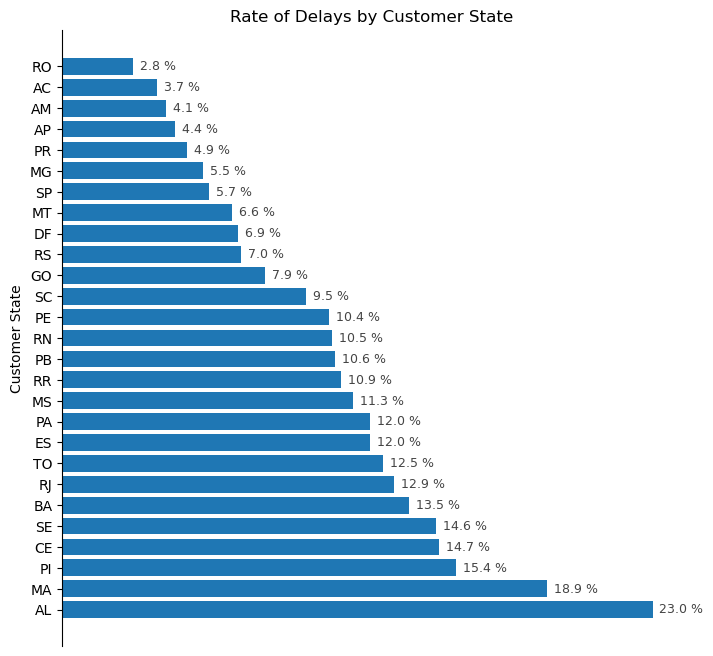

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

bars = plt.barh(df_chart["customer_state"], df_chart["delay_rate"])

ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars, labels=df_chart["delay_rate_formatted"], padding=5, fontsize=9, color="#444444")
plt.xlabel("Number of Delays")
plt.ylabel("Customer State")
plt.title("Rate of Delays by Customer State")
plt.show()


These percentages indicate how likely deliveries are to arrive late for customers in each state.

### Sellers States Delay Rate

In [212]:
final_table_df["seller_states"].unique()

array(['SP', 'MG', 'PR', 'SC', None, 'DF', 'RS', 'MG, SP', 'RJ', 'GO',
       'MA', 'ES', 'BA', 'SP, PR', 'PI', 'RO', 'MT, RJ', 'CE', 'MT',
       'PR, SP', 'RN', 'PE', 'SP, SC', 'RJ, SP', 'MG, SC', 'SP, SE',
       'MG, RS', 'RS, SC', 'MS', 'RS, SP', 'PB', 'SC, SP', 'MG, PR',
       'SP, MG', 'RJ, SC', 'SE', 'PR, SC', 'PA', 'RJ, SP, SC', 'CE, SP',
       'MS, SP', 'SP, RS', 'SP, BA', 'SC, PR', 'SP, RJ', 'RS, DF',
       'ES, SP', 'MA, SP', 'RJ, PR', 'SC, MG', 'PR, RJ, SP', 'PR, RJ',
       'SP, PE', 'PB, SP', 'DF, MG', 'RS, PR', 'PR, MG', 'MG, RO',
       'RS, MG', 'DF, SC', 'RJ, MG', 'AM', 'MS, PI', 'MG, SP, PR',
       'DF, PR', 'RJ, PR, SP', 'BA, MG', 'MG, RJ', 'SP, PR, RS', 'CE, MG',
       'SP, MS', 'SC, RJ', 'BA, PR', 'SP, DF', 'PR, DF', 'SP, RN',
       'PR, RS', 'SP, PB', 'MG, PR, SP', 'MG, GO', 'SP, ES', 'PE, MG',
       'PR, PE', 'PR, GO', 'SP, GO', 'AC', 'MG, SC, SP', 'SP, MT',
       'DF, SP', 'RN, SP', 'MT, SP'], dtype=object)

Note:

Seller states are grouped together for orders with multiple products and seperated by a comma.

eg, MG, SP

For rows that contains a comma, I'll seperate them into multiple rows with the same info. 
    
eg,
    order_id	                        customer_state	product_categories	        total_items	total_price	total_freight_value	seller_states	estimated_delivery_date	actual_delivery_date	Delayed
74	002f98c0f7efd42638ed6100ca699b42	RS	            brinquedos, consoles_games	2.0	        53.89	    39.73	            MG, SP	        2017-09-05	            2017-08-07 19:07:30	    False

Will become two rows:

    order_id	                        customer_state	product_categories	        total_items	total_price	total_freight_value	seller_states	estimated_delivery_date	actual_delivery_date	Delayed
74	002f98c0f7efd42638ed6100ca699b42	RS	            brinquedos, consoles_games	2.0	        53.89	    39.73	            MG	            2017-09-05	            2017-08-07 19:07:30	    False

    order_id	                        customer_state	product_categories	        total_items	total_price	total_freight_value	seller_states	estimated_delivery_date	actual_delivery_date	Delayed
75	002f98c0f7efd42638ed6100ca699b42	RS	            brinquedos, consoles_games	2.0	        53.89	    39.73	            SP	            2017-09-05	            2017-08-07 19:07:30	    False

In [ ]:
# Filter rows where seller_states contains a comma, to find orders with multiple sellers
filtered_df = final_table_df[final_table_df["seller_states"].str.contains(",", na=False)]
filtered_df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
74,002f98c0f7efd42638ed6100ca699b42,RS,"brinquedos, consoles_games",2.0,53.89,39.73,"MG, SP",2017-09-05,2017-08-07 19:07:30,False
272,00bcee890eba57a9767c7b5ca12d3a1b,DF,informatica_acessorios,4.0,672.41,100.09,"SP, PR",2017-08-21,2017-07-27 18:34:12,False
417,01144cadcf64b6427f0a6580a3033220,SP,beleza_saude,2.0,121.90,49.40,"MT, RJ",2018-03-12,2018-02-14 15:10:03,False
645,01b1a7fdae9ad1837d6ab861705a1fa5,SP,"cama_mesa_banho, utilidades_domesticas",2.0,108.99,26.85,"PR, SP",2017-06-21,2017-06-07 14:07:04,False
960,0282e83acfe3e7aaf60c871a4a9aca61,RJ,"market_place, beleza_saude",2.0,123.00,40.45,"SP, SC",2018-06-05,2018-05-17 17:35:33,False


In [ ]:
df_chart = final_table_df.copy() 
df_chart["seller_states"] = df_chart["seller_states"].str.split(",") # Split product_categories into a list
df_exploded = df_chart.explode("seller_states") # Explode the list so each product category gets its own row
df_exploded["seller_states"] = df_exploded["seller_states"].str.strip() # Strip whitespace from each product category
df_exploded.head() 

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False


To confirm, look at row 74 and 75 below. Notice how Seller States has been split correctly

In [223]:
df_exploded.iloc[74]

order_id                   002f98c0f7efd42638ed6100ca699b42
customer_state                                           RS
product_categories               brinquedos, consoles_games
total_items                                             2.0
total_price                                           53.89
total_freight_value                                   39.73
seller_states                                            MG
estimated_delivery_date                 2017-09-05 00:00:00
actual_delivery_date                    2017-08-07 19:07:30
Delayed                                               False
Name: 74, dtype: object

In [224]:
df_exploded.iloc[75]

order_id                   002f98c0f7efd42638ed6100ca699b42
customer_state                                           RS
product_categories               brinquedos, consoles_games
total_items                                             2.0
total_price                                           53.89
total_freight_value                                   39.73
seller_states                                            SP
estimated_delivery_date                 2017-09-05 00:00:00
actual_delivery_date                    2017-08-07 19:07:30
Delayed                                               False
Name: 74, dtype: object

In [225]:
# Group by seller_state and calculate delayed_orders, total_orders, and delay_rate
df_chart = (
    df_exploded.groupby('seller_states')
            .agg(
                delayed_orders=('Delayed', 'sum'),
                total_orders=('Delayed', 'count')
            )
            .reset_index()
)
df_chart["delay_rate"] = df_chart["delayed_orders"] / df_chart["total_orders"]
df_chart["delay_rate"] = df_chart["delay_rate"] * 100
df_chart["delay_rate_formatted"] = df_chart["delay_rate"].round(1).astype(str) + " %"
df_chart.sort_values(by="delay_rate", ascending=False, inplace=True)
df_chart.head()

,seller_states,delayed_orders,total_orders,delay_rate,delay_rate_formatted
1,AM,2,3,66.666667,66.7 %
7,MA,90,392,22.959184,23.0 %
11,PA,1,8,12.500000,12.5 %
17,RN,5,51,9.803922,9.8 %
3,CE,8,91,8.791209,8.8 %


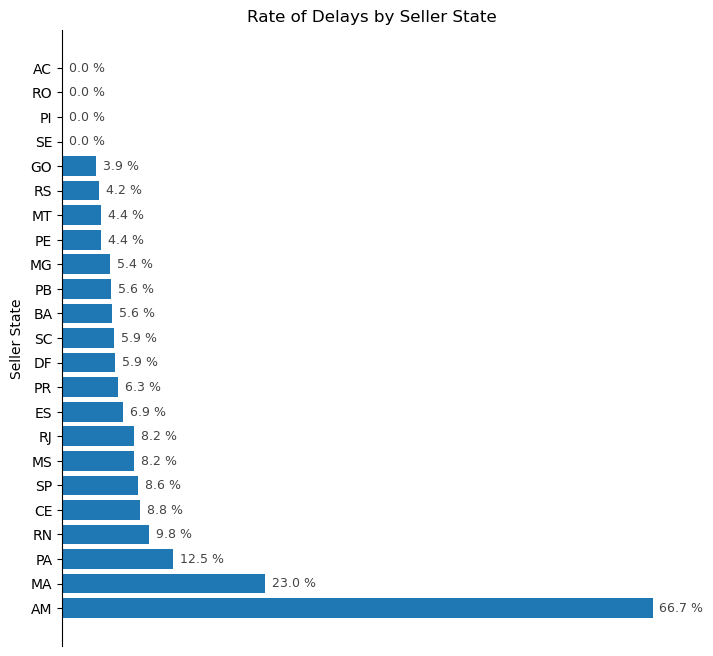

In [228]:
fig, ax = plt.subplots(figsize=(8, 8))

bars = plt.barh(df_chart["seller_states"], df_chart["delay_rate"])

ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars, labels=df_chart["delay_rate_formatted"], padding=5, fontsize=9, color="#444444")
plt.xlabel("Number of Delays")
plt.ylabel("Seller State")
plt.title("Rate of Delays by Seller State")
plt.show()


These percentages indicate how likely deliveries are to arrive late for sellers in each state.


## 2.	Which product categories are most prone to delays?

In [ ]:
df_chart = final_table_df.copy() 
df_chart['Delayed'] = df_chart['Delayed'].astype(int) # Convert Delayed to integer, changes True -> 1 and False -> 0

# Split product_categories into a list
df_chart['product_categories'] = df_chart['product_categories'].str.split(',') # Split product_categories into a list
df_exploded = df_chart.explode('product_categories') # Explode the list so each product category gets its own row
df_exploded['product_categories'] = df_exploded['product_categories'].str.strip() # Strip whitespace from each product category

# Group by product category and calculate delayed_orders, total_orders, and delay_rate
df_chart = (
    df_exploded.groupby('product_categories')
               .agg(
                   delayed_orders=('Delayed', 'sum'),
                   total_orders=('Delayed', 'count')
               )
               .reset_index()
)

df_chart['delay_rate'] = df_chart['delayed_orders'] / df_chart['total_orders'] *100
df_chart["delay_rate_formatted"] = df_chart["delay_rate"].round(1).astype(str) + " %"
df_chart = df_chart.sort_values(by='delay_rate', ascending=False)
df_chart.head()

,product_categories,delayed_orders,total_orders,delay_rate,delay_rate_formatted
15,casa_conforto_2,4,24,16.666667,16.7 %
52,moveis_colchao_e_estofado,5,38,13.157895,13.2 %
7,audio,45,350,12.857143,12.9 %
39,fashion_underwear_e_moda_praia,15,121,12.396694,12.4 %
49,livros_tecnicos,28,260,10.769231,10.8 %


In [ ]:
# getting the translated product categories
translate_df = pd.read_sql(text("""
	SELECT * 
	FROM  [dbo].[product_category_name_translation]
	"""), engine)

translate_df.rename(columns={'product_category_name': 'product_categories'}, inplace=True)
translate_df.head()

,product_categories,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
# merging df_chart with translate_df to get the translated product category names
merged_df = pd.merge(df_chart, translate_df, on='product_categories', how='left')
merged_df.head()

,product_categories,delayed_orders,total_orders,delay_rate,delay_rate_formatted,product_category_name_english
0,casa_conforto_2,4,24,16.666667,16.7 %,home_comfort_2
1,moveis_colchao_e_estofado,5,38,13.157895,13.2 %,furniture_mattress_and_upholstery
2,audio,45,350,12.857143,12.9 %,audio
3,fashion_underwear_e_moda_praia,15,121,12.396694,12.4 %,fashion_underwear_beach
4,livros_tecnicos,28,260,10.769231,10.8 %,books_technical


In [ ]:
merged_df.isna().sum() # check for null values. There are 2 null values in the translated names

product_categories               0
delayed_orders                   0
total_orders                     0
delay_rate                       0
delay_rate_formatted             0
product_category_name_english    2
dtype: int64

In [ ]:
# filling null values with the name in orignal language
merged_df["product_category_name_english"] = (
    merged_df["product_category_name_english"]
    .fillna(merged_df["product_category_name_english"])
    .astype(str)
)


In [13]:
merged_df.isna().sum()

product_categories               0
delayed_orders                   0
total_orders                     0
delay_rate                       0
delay_rate_formatted             0
product_category_name_english    0
dtype: int64

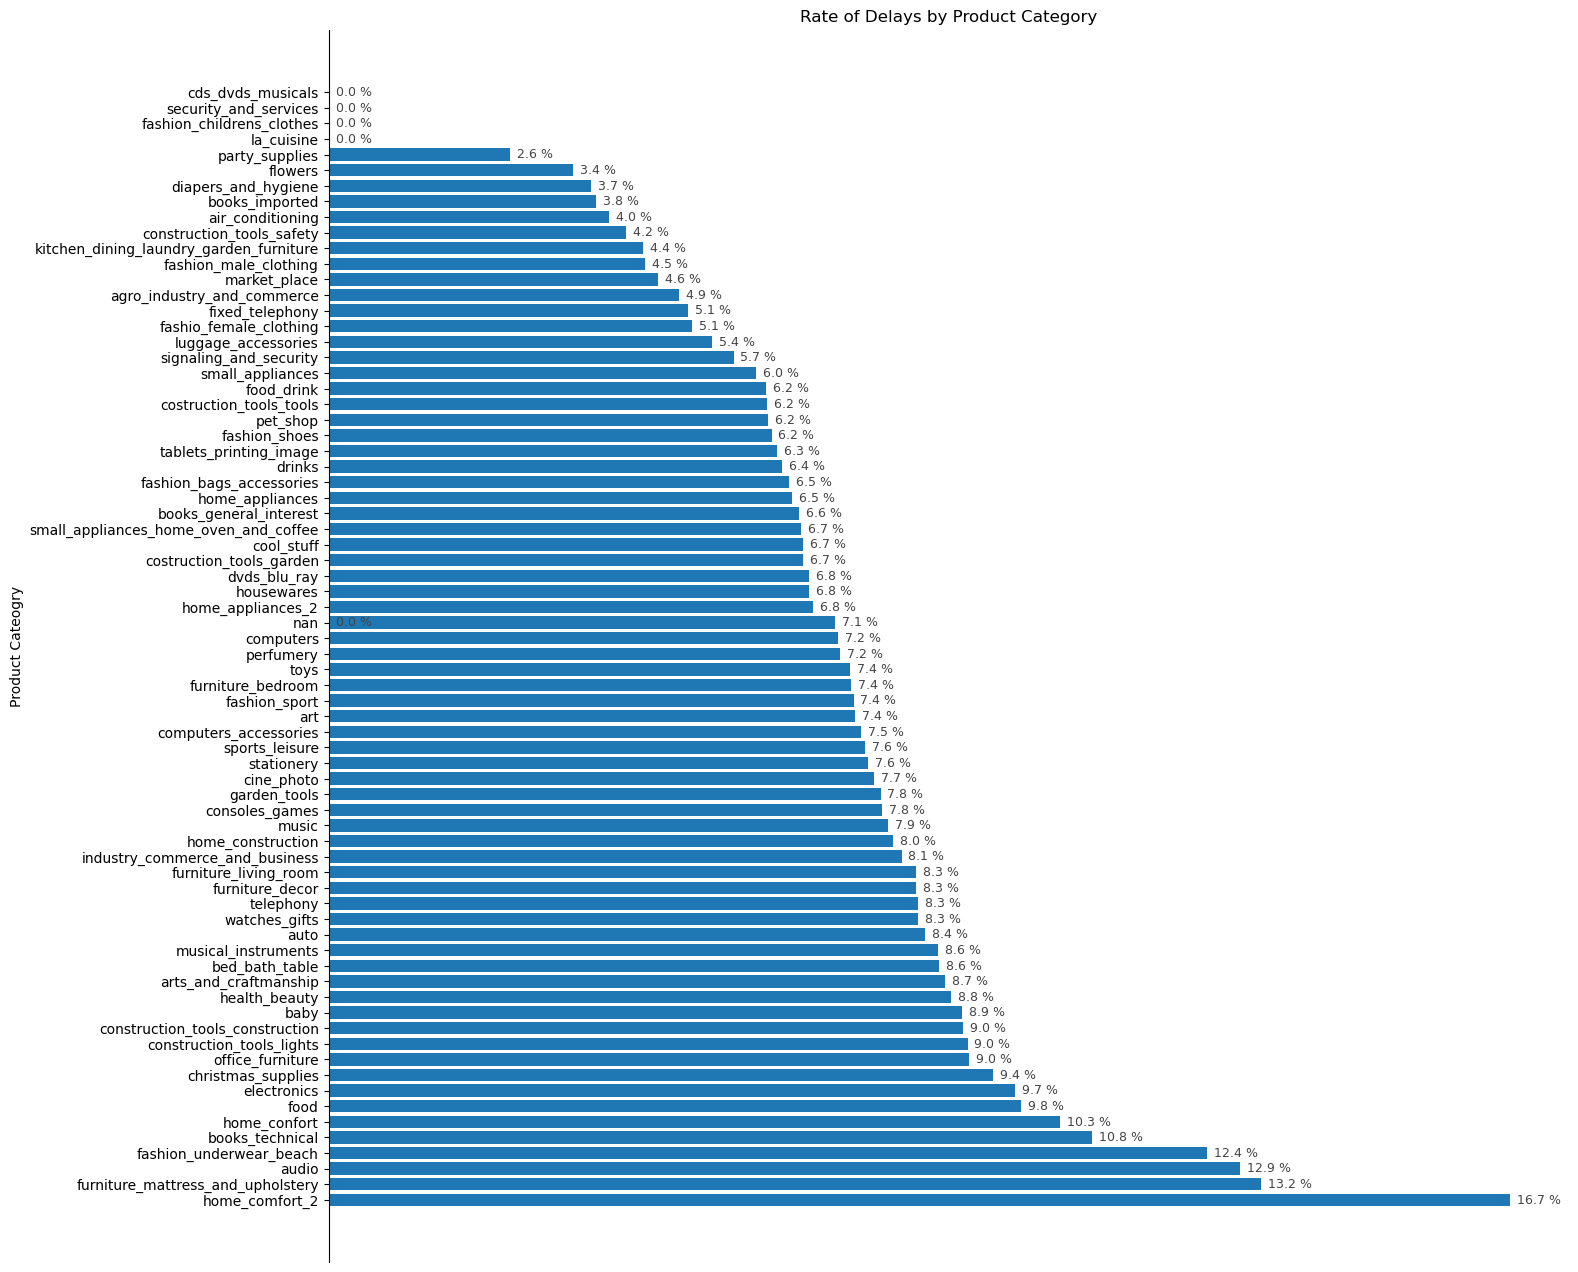

In [14]:
fig, ax = plt.subplots(figsize=(16, 16))

bars = plt.barh(merged_df["product_category_name_english"], merged_df["delay_rate"])

ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars, labels=merged_df["delay_rate_formatted"], padding=5, fontsize=9, color="#444444")
plt.xlabel("Number of Delays")
plt.ylabel("Product Cateogry")
plt.title("Rate of Delays by Product Category")
plt.show()


These percentages indicate how likely deliveries are to arrive late for each Product Category.

## 3.	Does freight cost correlate with delivery speed?

References:
- https://www.statology.org/point-biserial-correlation-python/
- https://stackoverflow.com/questions/55947160/correlation-between-boolean-and-continues-value
- https://numiqo.com/tutorial/point-biserial-correlation

To calculate correlation between a continuous column and boolean column, I'll use Point-Biserial Correlation



In [242]:
df_chart = final_table_df.copy()
df_chart.dtypes

order_id                           object
customer_state                     object
product_categories                 object
total_items                       float64
total_price                       float64
total_freight_value               float64
seller_states                      object
estimated_delivery_date    datetime64[ns]
actual_delivery_date       datetime64[ns]
Delayed                              bool
dtype: object

In [ ]:
df_chart['Delayed'] = df_chart['Delayed'].astype(int) # convert Delayed to integer, changes True -> 1 and False -> 0
df_chart.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,0
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,0
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,0
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,0


In [ ]:
df_chart.isna().sum() # check for null values

order_id                      0
customer_state                0
product_categories         2164
total_items                 775
total_price                 775
total_freight_value         775
seller_states               775
estimated_delivery_date       0
actual_delivery_date       2965
Delayed                       0
dtype: int64

In [ ]:
df_chart = df_chart[["total_freight_value", "Delayed"]] # selecting only relevant columns
df_chart.isna().sum()

total_freight_value    775
Delayed                  0
dtype: int64

In [ ]:
# dropping nulls
df_chart = df_chart.dropna()
df_chart.isna().sum()

total_freight_value    0
Delayed                0
dtype: int64

In [249]:
#calculate point-biserial correlation
result = stats.pointbiserialr(df_chart['total_freight_value'], df_chart['Delayed'])

full_pvalue = format(result.pvalue, 'f')   # full decimal
full_stat = format(result.statistic, 'f')  # full decimal (if needed)

print("Correlation:", full_stat)
print("p-value:", full_pvalue)


Correlation: 0.024387
p-value: 0.000000


Null hypothesis: The correlation coefficient r = 0 (There is no correlation)
Alternative hypothesis: The correlation coefficient r ≠ 0 (There is a correlation)

Using alpha = 0.05

Since P-Value = 0.000000 < alpha = 0.05, we reject the null hypothesis.
we reject the null hypothesis and conclude that there is a statistically significant correlation between freight cost and delivery delay.

Lookign at the correlation value:

Positive -> Higher freight cost = higher chance of delay

Negative -> Higher freight cost = lower chance of delay (faster delivery)

Near 0 -> No relationship

Since Correlation value = 0.042426, this indicates a very weak positive correlation between freight cost and delivery delay. 

<Figure size 800x600 with 0 Axes>

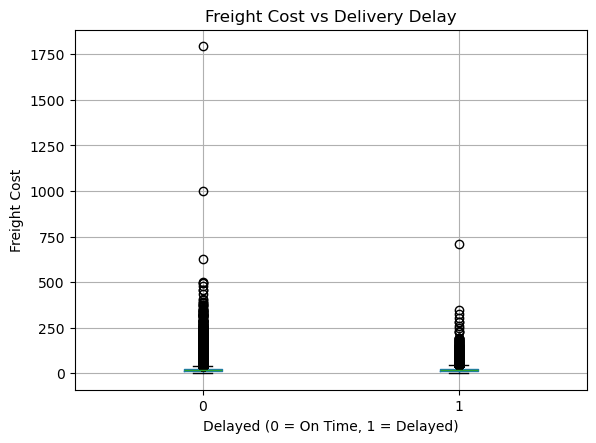

In [253]:
plt.figure(figsize=(8,6))
df_chart.boxplot(column="total_freight_value", by="Delayed")

plt.title("Freight Cost vs Delivery Delay")
plt.suptitle("")   # Remove automatic title
plt.xlabel("Delayed (0 = On Time, 1 = Delayed)")
plt.ylabel("Freight Cost")
plt.show()


Conclusion:


There is a weak positive correlation (corr = 0.12) between freight cost and delivery delay, which is statistically significant (p < 0.05). 

This suggests that as freight costs increase, there is a slight tendency for deliveries to be delayed.  

## 4.	Do orders with multiple items get delayed more often?

In [ ]:
# Filter rows where product_categories contains a comma -> this will filter out orders with multiple items
df_chart = final_table_df[final_table_df["product_categories"].str.contains(",", na=False)]
df_chart

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
74,002f98c0f7efd42638ed6100ca699b42,RS,"brinquedos, consoles_games",2.0,53.89,39.73,"MG, SP",2017-09-05,2017-08-07 19:07:30,False
135,005d9a5423d47281ac463a968b3936fb,SP,"bebes, brinquedos",3.0,99.97,45.28,RS,2017-11-17,2017-10-27 19:19:43,False
492,014405982914c2cde2796ddcf0b8703d,RJ,"perfumaria, esporte_lazer",2.0,49.23,29.20,SP,2017-08-17,2017-07-31 15:53:33,False
645,01b1a7fdae9ad1837d6ab861705a1fa5,SP,"cama_mesa_banho, utilidades_domesticas",2.0,108.99,26.85,"PR, SP",2017-06-21,2017-06-07 14:07:04,False
697,01cce1175ac3c4a450e3a0f856d02734,SP,"papelaria, ferramentas_jardim",2.0,96.23,27.51,SP,2018-08-06,2018-07-21 16:27:44,False
...,...,...,...,...,...,...,...,...,...,...
98846,fe64170e936bc5f6a6a41def260984b9,SP,"cama_mesa_banho, moveis_decoracao",2.0,199.80,33.56,"PR, SP",2018-05-22,2018-05-03 19:11:31,False
98854,fe678293ea3bb6607a15b2e320e91722,SP,"beleza_saude, esporte_lazer",2.0,78.39,23.39,SP,2018-01-24,2018-01-09 04:18:22,False
99082,ff00a56fe9475a175cd651d77c707a09,RS,"cama_mesa_banho, casa_conforto",3.0,296.70,55.57,SP,2017-12-26,2017-12-18 13:14:05,False
99185,ff40f38705c95a8eceea1a0db29bff66,SC,"audio, relogios_presentes",2.0,173.00,36.97,SP,2018-06-04,2018-05-15 23:11:25,False


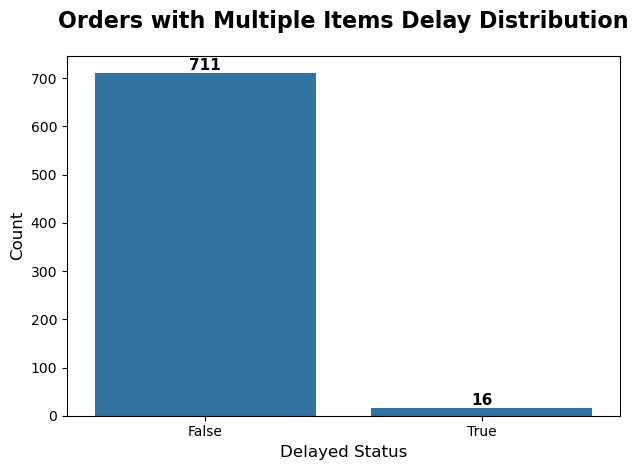

In [17]:
ax = sns.countplot(x='Delayed', data=df_chart)
 
plt.title('Orders with Multiple Items Delay Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Delayed Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add data labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

A total of 727 orders contained multiple items, out of which 711 orders were delayed, resulting in a delay rate of approximately 97.7%. This indicates that orders with multiple items have a significant likelihood of experiencing delivery delays.

## 5.	Seasonality: 

### Monthly Volume

In [ ]:
# getting order purchase timestamp along with final_table
df = pd.read_sql(text("""
	SELECT * 
	FROM final_table t 
	LEFT JOIN 
		(
			SELECT order_id, order_purchase_timestamp
			FROM dbo.orders
		) o
		ON t.order_id = o.order_id

	"""), engine)

df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp
0,136cce7faa42fdb2cefd53fdc79a6098,RS,None,1.0,49.90,16.05,SP,2017-05-09,NaT,False,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08
1,6514b8ad8028c9f2cc2374ded245783f,RJ,automotivo,1.0,59.99,15.17,SP,2017-06-07,2017-05-26 12:55:51,False,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30
2,82566a660a982b15fb86e904c8d32918,MG,perfumaria,1.0,31.90,18.23,SP,2018-07-18,2018-06-19 12:05:52,False,82566a660a982b15fb86e904c8d32918,2018-06-07 10:06:19
3,dcb36b511fcac050b97cd5c05de84dc3,GO,perfumaria,1.0,132.40,14.05,DF,2018-07-04,2018-06-21 15:34:32,False,dcb36b511fcac050b97cd5c05de84dc3,2018-06-07 19:03:12
4,203096f03d82e0dffbc41ebc2e2bcfb7,SP,beleza_saude,1.0,109.90,8.96,SP,2017-09-28,2017-10-09 22:23:46,True,203096f03d82e0dffbc41ebc2e2bcfb7,2017-09-18 14:31:30


In [ ]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors='coerce') # Convert to datetime
df.dtypes

order_id                            object
customer_state                      object
product_categories                  object
total_items                        float64
total_price                        float64
total_freight_value                float64
seller_states                       object
estimated_delivery_date     datetime64[ns]
actual_delivery_date        datetime64[ns]
Delayed                               bool
order_id                            object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [ ]:
df['purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M') # Extract year and month as period

# group by purchase_month to get monthly order volume
monthly_volume = (
    df.groupby('purchase_month')['order_id']
            .count()
            .reset_index()
            .rename(columns={'order_id': 'monthly_orders'})
)

In [60]:
monthly_volume.head()

,purchase_month,monthly_orders,monthly_orders
0,2016-09,4,4
1,2016-10,324,324
2,2016-12,1,1
3,2017-01,800,800
4,2017-02,1780,1780


In [ ]:
monthly_volume = monthly_volume.loc[:, ~monthly_volume.columns.duplicated()] # removing duplicate column
monthly_volume.head()

,purchase_month,monthly_orders
0,2016-09,4
1,2016-10,324
2,2016-12,1
3,2017-01,800
4,2017-02,1780


In [ ]:
monthly_volume.isna().sum() # check for null values

purchase_month    0
monthly_orders    0
dtype: int64

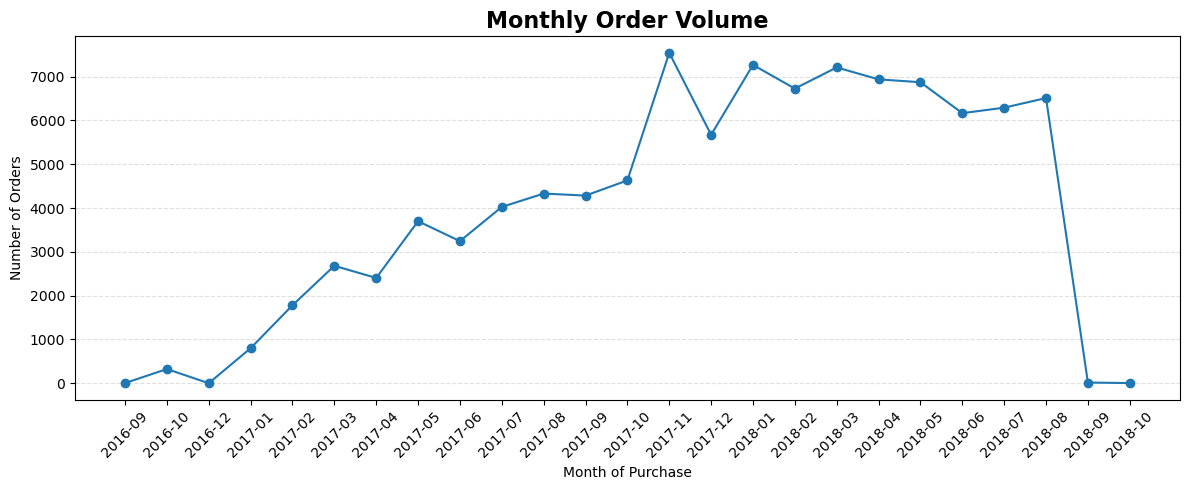

In [65]:
plt.figure(figsize=(12,5))
plt.plot(monthly_volume['purchase_month'].astype(str), monthly_volume['monthly_orders'], marker='o')

plt.title("Monthly Order Volume", fontsize=16, fontweight='bold')
plt.xlabel("Month of Purchase")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### Decompose the time series

In [ ]:
df = monthly_volume.copy()

df['purchase_month'] = df['purchase_month'].dt.to_timestamp() # Convert Period to Timestamp for resampling

df.set_index('purchase_month', inplace=True) # Set purchase_month as index

df = df['monthly_orders'].resample('M').sum() # resample to ensure all months are present

df.isna().sum() # check for null values

C:\Users\Shivan\AppData\Local\Temp\ipykernel_24880\391577940.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['monthly_orders'].resample('M').sum()


0

In [ ]:
df.head() # display the time series data

purchase_month
2016-09-30      4
2016-10-31    324
2016-11-30      0
2016-12-31      1
2017-01-31    800
Freq: ME, Name: monthly_orders, dtype: int64

In [ ]:
decomposition = seasonal_decompose(df, model='additive', period=12) # Decompose the time series 

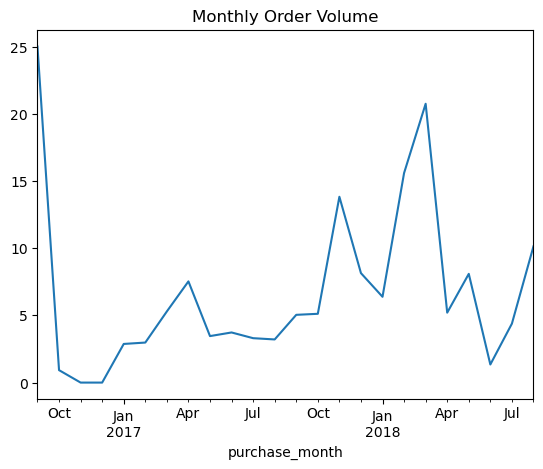

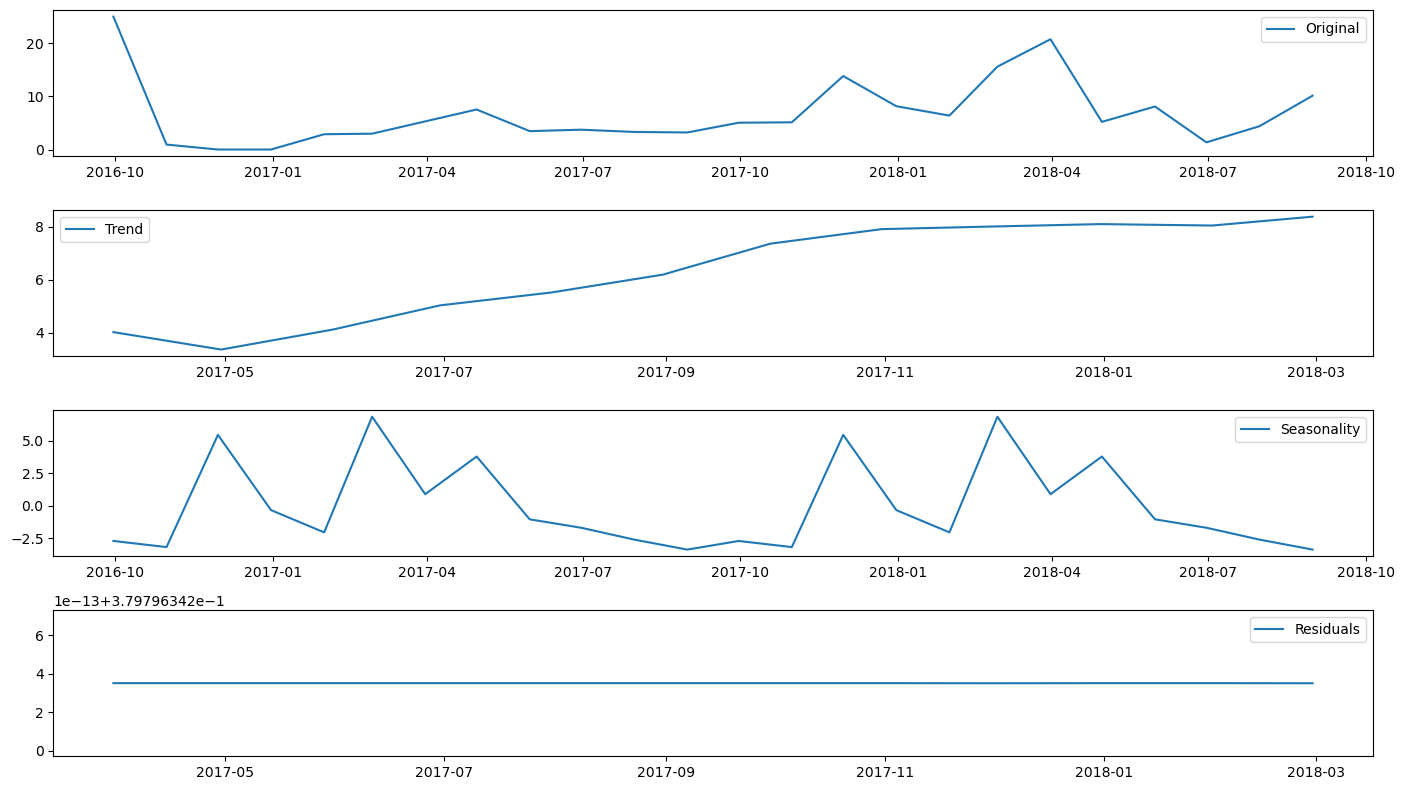

In [ ]:
df.plot(title='Monthly Order Volume')

#  Plotting monthly decomposition sales for trends, seasonality and residuals
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

Original Time Series: 
- The first subplot displays the entire original time series data. It shows the raw and unprocessed data over time.

Trend Component: 
- The second subplot shows the long-term movement or trend in the data. 
- There is a downward trend uptill May 2017 but shows a clear upward trend after, suggesting overall growth in the monthly orders.

Seasonal Component: 
- Seasonality in time series data shows regular patterns that repeat over time. These patterns repeat at regular times, like every day, month, or year.
- The seasonal component shows periodic fluctuations, meaning the data has a repeating pattern at regular intervals. The presence of strong seasonal effects suggests that the data exhibits cyclical behavior.

Residual Component: 
- The final subplot displays the residuals. They represent the random noise or variability left after removing the trend and seasonality from the original data. 
- From the plot it is visible that residual  is constant 

### Monthly delay

In [ ]:
# getting order purchase timestamp along with final_table
df = pd.read_sql(text("""
SELECT * 
FROM final_table t 
LEFT JOIN 
		(
			SELECT order_id, order_purchase_timestamp
			from dbo.orders
		) o
		ON t.order_id = o.order_id

"""), engine)

df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp
0,136cce7faa42fdb2cefd53fdc79a6098,RS,None,1.0,49.90,16.05,SP,2017-05-09,NaT,False,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08
1,6514b8ad8028c9f2cc2374ded245783f,RJ,automotivo,1.0,59.99,15.17,SP,2017-06-07,2017-05-26 12:55:51,False,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30
2,82566a660a982b15fb86e904c8d32918,MG,perfumaria,1.0,31.90,18.23,SP,2018-07-18,2018-06-19 12:05:52,False,82566a660a982b15fb86e904c8d32918,2018-06-07 10:06:19
3,dcb36b511fcac050b97cd5c05de84dc3,GO,perfumaria,1.0,132.40,14.05,DF,2018-07-04,2018-06-21 15:34:32,False,dcb36b511fcac050b97cd5c05de84dc3,2018-06-07 19:03:12
4,203096f03d82e0dffbc41ebc2e2bcfb7,SP,beleza_saude,1.0,109.90,8.96,SP,2017-09-28,2017-10-09 22:23:46,True,203096f03d82e0dffbc41ebc2e2bcfb7,2017-09-18 14:31:30


In [ ]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors='coerce') # Convert to datetime

In [ ]:
df['purchase_month'] = df['order_purchase_timestamp'].dt.to_period('M') # Extract year and month as period
df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp,purchase_month
0,136cce7faa42fdb2cefd53fdc79a6098,RS,None,1.0,49.90,16.05,SP,2017-05-09,NaT,False,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,2017-04
1,6514b8ad8028c9f2cc2374ded245783f,RJ,automotivo,1.0,59.99,15.17,SP,2017-06-07,2017-05-26 12:55:51,False,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05
2,82566a660a982b15fb86e904c8d32918,MG,perfumaria,1.0,31.90,18.23,SP,2018-07-18,2018-06-19 12:05:52,False,82566a660a982b15fb86e904c8d32918,2018-06-07 10:06:19,2018-06
3,dcb36b511fcac050b97cd5c05de84dc3,GO,perfumaria,1.0,132.40,14.05,DF,2018-07-04,2018-06-21 15:34:32,False,dcb36b511fcac050b97cd5c05de84dc3,2018-06-07 19:03:12,2018-06
4,203096f03d82e0dffbc41ebc2e2bcfb7,SP,beleza_saude,1.0,109.90,8.96,SP,2017-09-28,2017-10-09 22:23:46,True,203096f03d82e0dffbc41ebc2e2bcfb7,2017-09-18 14:31:30,2017-09


In [ ]:
# group by purchase_month to get monthly order volume
monthly_volume = (
    df.groupby('purchase_month')['order_id']
            .count()
            .reset_index()
            .rename(columns={'order_id': 'monthly_orders'})
)
monthly_volume = monthly_volume.loc[:, ~monthly_volume.columns.duplicated()]
monthly_volume.head()

,purchase_month,monthly_orders
0,2016-09,4
1,2016-10,324
2,2016-12,1
3,2017-01,800
4,2017-02,1780


In [ ]:
delayed_df = df[df['Delayed']] # Filter for delayed orders
delayed_df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp,purchase_month
4,203096f03d82e0dffbc41ebc2e2bcfb7,SP,beleza_saude,1.0,109.9,8.96,SP,2017-09-28,2017-10-09 22:23:46,True,203096f03d82e0dffbc41ebc2e2bcfb7,2017-09-18 14:31:30,2017-09
8,6ea2f835b4556291ffdc53fa0b3b95e8,SP,utilidades_domesticas,1.0,339.0,17.12,SC,2017-12-21,2017-12-28 18:59:23,True,6ea2f835b4556291ffdc53fa0b3b95e8,2017-11-24 21:27:48,2017-11
27,6a0a8bfbbe700284feb0845d95e0867f,RJ,moveis_decoracao,1.0,83.9,17.84,SP,2017-12-11,2017-12-28 19:43:00,True,6a0a8bfbbe700284feb0845d95e0867f,2017-11-22 11:32:22,2017-11
44,df5c9b471c8cb2bf4fd5d986d8811ed1,MG,consoles_games,1.0,18.0,15.10,SP,2017-10-05,2017-10-06 21:42:11,True,df5c9b471c8cb2bf4fd5d986d8811ed1,2017-09-13 22:21:07,2017-09
64,8563039e855156e48fccee4d611a3196,TO,ferramentas_jardim,1.0,78.0,28.95,SP,2018-03-20,2018-03-20 00:59:25,True,8563039e855156e48fccee4d611a3196,2018-02-17 15:59:46,2018-02


In [ ]:
# group by purchase_month to get monthly delayed order volume
monthly_volume_delayed = (
    delayed_df.groupby('purchase_month')['Delayed']
            .count()
            .reset_index()
            .rename(columns={'Delayed': 'monthly_orders_delayed'})
)
monthly_volume_delayed.head()

,purchase_month,monthly_orders_delayed
0,2016-09,1
1,2016-10,3
2,2017-01,23
3,2017-02,53
4,2017-03,142


In [ ]:
# Merging monthly total orders with monthly delayed orders
merged_df = pd.merge(monthly_volume_delayed, monthly_volume, on='purchase_month')
merged_df.head()

,purchase_month,monthly_orders_delayed,monthly_orders
0,2016-09,1,4
1,2016-10,3,324
2,2017-01,23,800
3,2017-02,53,1780
4,2017-03,142,2682


In [ ]:
# calculating delayed rate
merged_df["delayed_rate"] = merged_df["monthly_orders_delayed"] / merged_df["monthly_orders"] * 100
merged_df.head()

,purchase_month,monthly_orders_delayed,monthly_orders,delayed_rate
0,2016-09,1,4,25.000000
1,2016-10,3,324,0.925926
2,2017-01,23,800,2.875000
3,2017-02,53,1780,2.977528
4,2017-03,142,2682,5.294556


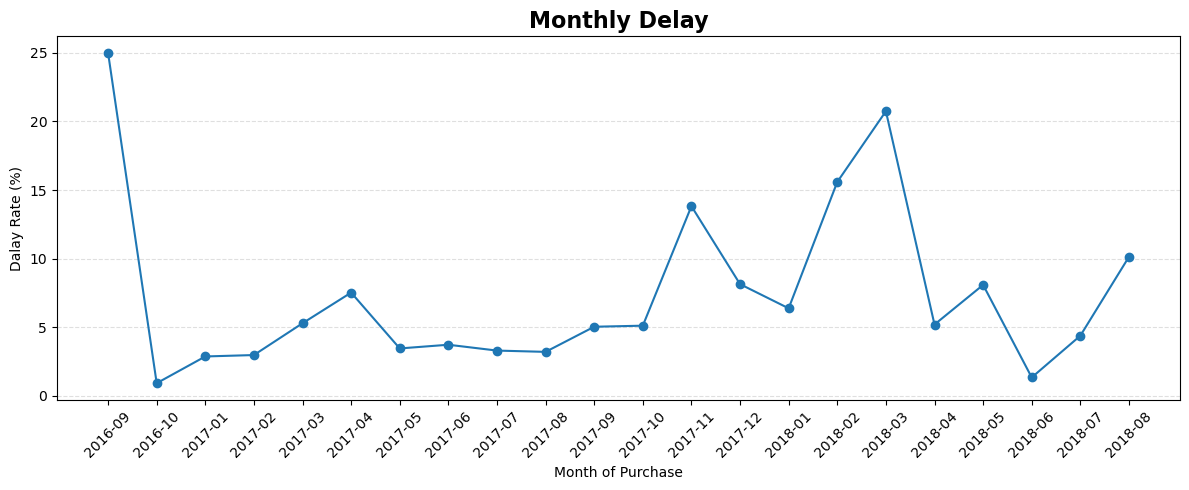

In [14]:
plt.figure(figsize=(12,5))
plt.plot(merged_df['purchase_month'].astype(str), merged_df['delayed_rate'], marker='o')

plt.title("Monthly Delay", fontsize=16, fontweight='bold')
plt.xlabel("Month of Purchase")
plt.ylabel("Dalay Rate (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
df = merged_df.copy() 
 
df['purchase_month'] = df['purchase_month'].dt.to_timestamp() # Convert Period to Timestamp for resampling
  
df.set_index('purchase_month', inplace=True) # Set purchase_month as index
 
df = df['delayed_rate'].resample('M').sum() # resample to ensure all months are present

df.isna().sum() # check for null values

C:\Users\Shivan\AppData\Local\Temp\ipykernel_33232\2628823840.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['delayed_rate'].resample('M').sum()


0

In [16]:
df.head()

purchase_month
2016-09-30    25.000000
2016-10-31     0.925926
2016-11-30     0.000000
2016-12-31     0.000000
2017-01-31     2.875000
Freq: ME, Name: delayed_rate, dtype: float64

In [ ]:
decomposition = seasonal_decompose(df, model='additive', period=12) # Decompose the time series

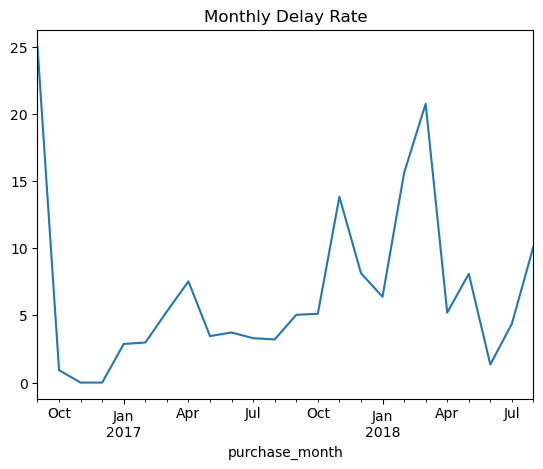

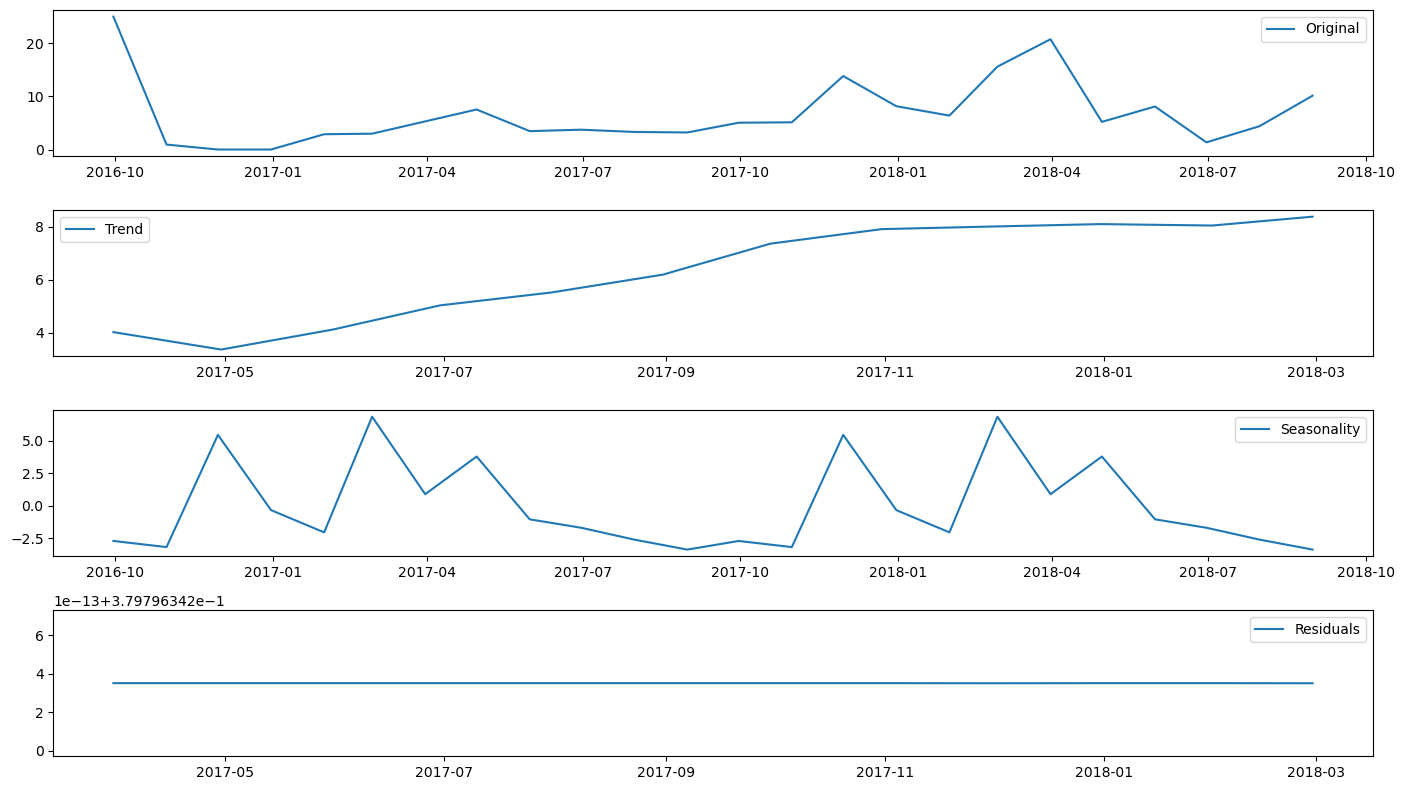

In [ ]:
df.plot(title='Monthly Delay Rate')

#  Plotting monthly decomposition sales for trends, seasonality and residuals
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

Original Time Series: 
- The first subplot displays the entire original time series data. It shows the raw and unprocessed data over time.

Trend Component: 
- The second subplot shows the long-term movement or trend in the data. 
- There is a downward trend uptill May 2017 but shows a clear upward trend after, suggesting overall growth in the monthly orders.

Seasonal Component: 
- Seasonality in time series data shows regular patterns that repeat over time. These patterns repeat at regular times, like every day, month, or year.
- The seasonal component shows periodic fluctuations, meaning the data has a repeating pattern at regular intervals. The presence of strong seasonal effects suggests that the data exhibits cyclical behavior.

Residual Component: 
- The final subplot displays the residuals. They represent the random noise or variability left after removing the trend and seasonality from the original data. 
- From the plot it is visible that residual  is constant 

## 6.	Customer behavior:

### Average order size by state

In [281]:
df = final_table_df

In [282]:
df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False


In [ ]:
# finding the number of products in each order, by converting the product_categories string into a list and counting the length of the list
df['number_of_products'] = (
    df['product_categories']
        .fillna('')
        .apply(lambda x: len([c.strip() for c in str(x).split(',')]) if x != '' else 0)
)
df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False,1
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False,1
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False,1
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False,1


In [284]:
df[df['number_of_products'] == 3].head() #confirmation

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,number_of_products
11318,1d23106803c48c391366ff224513fb7f,RS,"cama_mesa_banho, moveis_decoracao, bebes",4.0,148.79,65.40,SP,2018-03-02,2018-02-09 21:38:39,False,3
12339,1fcbc88015c88c1a14d4b8ec35ea8ed7,BA,"esporte_lazer, pet_shop, moveis_decoracao",3.0,125.28,118.12,SP,2018-08-08,2018-07-14 11:44:29,False,3
18383,2f8f31eb2f7b6572836d662a6625c8e4,MG,"instrumentos_musicais, automotivo, fashion_bol...",3.0,94.70,32.88,MG,2017-03-06,2017-02-15 12:54:49,False,3
18647,3040863957c9336e7389512584639bb5,RS,"moveis_decoracao, utilidades_domesticas, relog...",3.0,197.89,60.96,"PR, SP",2018-05-02,2018-04-05 20:32:38,False,3
18715,306b4ec62d908535f2bfa2877665e899,SP,"market_place, cama_mesa_banho, perfumaria",3.0,241.79,34.56,"MG, SP",2018-01-18,2017-12-16 14:57:12,False,3


In [285]:
df.shape

(99441, 11)

In [ ]:
# grouping the datadrame by customer_state and finding the average order size per state
avg_order_size = (
    df.groupby('customer_state')['number_of_products']
            .mean().round(3)
            .reset_index()
            .rename(columns={'number_of_products': 'avg_order_size'})
)

avg_order_size.head()

,customer_state,avg_order_size
0,AC,0.988
1,AL,0.985
2,AM,0.986
3,AP,1.000
4,BA,0.987


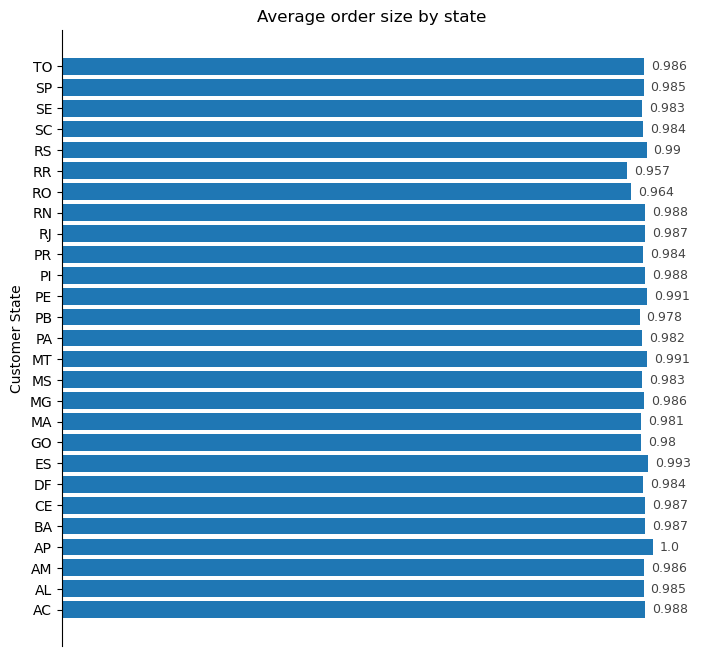

In [287]:
fig, ax = plt.subplots(figsize=(8, 8))

bars = plt.barh(avg_order_size["customer_state"], avg_order_size["avg_order_size"])

ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars, labels=avg_order_size["avg_order_size"], padding=5, fontsize=9, color="#444444")
plt.xlabel("Average Order Size")
plt.ylabel("Customer State")
plt.title("Average order size by state")
plt.show()

On average, The number of products per order across all customer states, is 1 product.

In [ ]:
# confirmation
ac_df = final_table_df[final_table_df["customer_state"] == 'AC']
ac_df

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp,purchase_month,number_of_products
45,62686dac3e596036e72fe0beb571e45e,AC,automotivo,1.0,285.00,27.02,SP,2017-11-27,2017-10-26 21:23:42,False,62686dac3e596036e72fe0beb571e45e,2017-10-13 13:10:42,2017-10,1
144,0d4628fecf8a76472ac1da3ebef92072,AC,eletronicos,1.0,239.00,77.19,MG,2018-02-14,2018-01-09 21:52:13,False,0d4628fecf8a76472ac1da3ebef92072,2017-12-23 16:45:12,2017-12,1
638,a7abe735fa002a72636ab38fcac70330,AC,informatica_acessorios,1.0,31.90,31.02,MG,2017-08-24,2017-08-08 22:16:44,False,a7abe735fa002a72636ab38fcac70330,2017-07-21 01:12:34,2017-07,1
1059,0c956783114b7ac9633e16c494c191ce,AC,moveis_decoracao,1.0,88.34,52.98,SP,2018-03-02,2018-02-06 01:43:56,False,0c956783114b7ac9633e16c494c191ce,2018-01-14 20:05:34,2018-01,1
2281,d445a6e277eaa62900bc18d453d96d76,AC,telefonia,1.0,199.00,26.42,DF,2017-09-06,2017-08-14 20:37:25,False,d445a6e277eaa62900bc18d453d96d76,2017-08-03 10:39:39,2017-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93698,3c842261892c32fb5ce15222b72fa6e0,AC,esporte_lazer,1.0,549.00,69.60,SP,2017-05-23,2017-05-05 16:57:48,False,3c842261892c32fb5ce15222b72fa6e0,2017-04-18 13:05:04,2017-04,1
94077,57be20dc5f786ed372add8e3f28be447,AC,moveis_decoracao,6.0,479.40,167.04,SP,2018-08-30,2018-08-09 13:59:42,False,57be20dc5f786ed372add8e3f28be447,2018-07-26 13:13:19,2018-07,1
94506,e494c29003c61332fdf1340bba650cd3,AC,automotivo,1.0,45.00,42.38,SP,2017-12-15,2017-11-23 16:46:57,False,e494c29003c61332fdf1340bba650cd3,2017-11-06 11:29:00,2017-11,1
96504,5b829c37201779df841d79b1875ca7ef,AC,automotivo,1.0,144.99,26.04,SP,2018-01-05,2017-12-14 01:09:55,False,5b829c37201779df841d79b1875ca7ef,2017-11-27 19:57:02,2017-11,1


In [129]:
ac_df["number_of_products"].sum()

80

In [130]:
80/81

0.9876543209876543

### Repeat customer patterns

- Repeat customer patterns help you understand loyalty and buying behaviour over time.
- They tell you whether customers stay engaged or disappear after 1 order.


1. Identfying which customers are always purchsaing from the compnay. If a customer repeatly buys from the company, we'll calssify them in a certain criteria. (RFM Analysis)

2. I want to also identify which products are being bought repeatly by the customers. Eg, If a customers repeatedly buy 2 products together, such as  bread and milk, can we confirm that those 2 products are always most likely to be bought together again in the future? (Association Rule)

#### RFM Analysis 


Reference:
- https://www.geeksforgeeks.org/data-analysis/rfm-analysis-analysis-using-python/

RFM stands for:

R – Recency:

- How recently did the customer buy?
(Recent buyers are more likely to buy again.)

F – Frequency:

- How many times have they purchased?
(Frequent buyers are loyal.)

M – Monetary:

- How much money have they spent overall?
(Big spenders are valuable customers.)


In [ ]:
# get data form finat_table and join with orders to get order purchase timestamp. The order_purchase_timestamp is the date the order was placed 
df = pd.read_sql(text("""
	SELECT * 
	FROM final_table t 
	LEFT JOIN 
		(
			SELECT order_id, customer_id, order_purchase_timestamp
			FROM dbo.orders
		) o
		ON t.order_id = o.order_id
	"""), engine)

df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,customer_id,order_purchase_timestamp
0,e6ce16cb79ec1d90b1da9085a6118aeb,RJ,ferramentas_jardim,2.0,198.0,61.06,ES,2017-06-07,2017-05-29 11:18:31,False,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10
1,82ddf38783ac58b33eb4a6e617f85a22,SP,perfumaria,1.0,56.9,15.15,RJ,2017-07-27,2017-07-13 23:41:18,False,82ddf38783ac58b33eb4a6e617f85a22,080dfe3c493444a1fe042b4668e4b01d,2017-07-05 13:08:23
2,34513ce0c4fab462a55830c0989c7edb,SP,informatica_acessorios,1.0,98.0,16.13,RS,2017-08-08,2017-07-19 14:04:48,False,34513ce0c4fab462a55830c0989c7edb,7711cf624183d843aafe81855097bc37,2017-07-13 19:58:11
3,44a10a741d51010c1440fc7337b5ff6e,RJ,esporte_lazer,1.0,69.9,20.98,SP,2018-03-07,2018-02-22 22:04:08,False,44a10a741d51010c1440fc7337b5ff6e,08185246997b160bfdc98c4804abae71,2018-02-10 09:25:05
4,6af5d730993da615e313627e0ac37f87,MG,fashion_bolsas_e_acessorios,1.0,124.0,14.95,MG,2018-05-25,2018-05-14 17:14:56,False,6af5d730993da615e313627e0ac37f87,f48205601396f53905f1d9e5370f621e,2018-05-07 14:33:53


In [23]:
# Ensure date column is datetime
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

In [28]:
# Calculate Recency
df_recency = df.groupby(by='customer_id', as_index=False)['order_purchase_timestamp'].max()
df_recency.columns = ['customer_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,customer_id,LastPurchaseDate,Recency
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,337
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,458
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,596
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,427
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,198


In [30]:
# Calculate Frequency
frequency_df = df.drop_duplicates().groupby(by=['customer_id'], as_index=False)['order_purchase_timestamp'].count()
frequency_df.columns = ['customer_id', 'Frequency']
frequency_df.head()

,customer_id,Frequency
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1


In [39]:
# Calculate Monetary Value
df['total_order_value'] = df['total_price'] + df['total_freight_value'] # as stated under  "About this file". 'https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv
df['Total'] = df['total_order_value']  # Total spent by each customer
monetary_df = df.groupby(by='customer_id', as_index=False)['Total'].sum()
monetary_df.columns = ['customer_id', 'Monetary']
monetary_df.head()

,customer_id,Monetary
0,00012a2ce6f8dcda20d059ce98491703,114.74
1,000161a058600d5901f007fab4c27140,67.41
2,0001fd6190edaaf884bcaf3d49edf079,195.42
3,0002414f95344307404f0ace7a26f1d5,179.35
4,000379cdec625522490c315e70c7a9fb,107.01


In [40]:
# Merge Recency, Frequency and Monetary Data
rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(columns='LastPurchaseDate')
rfm_df.head()

,customer_id,Recency,Frequency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,337,1,114.74
1,000161a058600d5901f007fab4c27140,458,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,596,1,195.42
3,0002414f95344307404f0ace7a26f1d5,427,1,179.35
4,000379cdec625522490c315e70c7a9fb,198,1,107.01


In [41]:
# Rank Customers Based on Recency, Frequency and Monetary
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

In [42]:
# Normalize the Ranks- to a scale of 0-100 to make them easier to compare. This makes the ranks more consistent across different customers and helps in calculating the final RFM score.
rfm_df['R_rank_norm'] = (rfm_df['R_rank'] / rfm_df['R_rank'].max()) * 100
rfm_df['F_rank_norm'] = (rfm_df['F_rank'] / rfm_df['F_rank'].max()) * 100
rfm_df['M_rank_norm'] = (rfm_df['M_rank'] / rfm_df['M_rank'].max()) * 100

In [43]:
# Drop Individual Ranks
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,00012a2ce6f8dcda20d059ce98491703,337,1,114.74,34.485949,100.0,54.615300
1,000161a058600d5901f007fab4c27140,458,1,67.41,16.921174,100.0,29.643708
2,0001fd6190edaaf884bcaf3d49edf079,596,1,195.42,2.875589,100.0,78.945304
3,0002414f95344307404f0ace7a26f1d5,427,1,179.35,21.231289,100.0,75.779105
4,000379cdec625522490c315e70c7a9fb,198,1,107.01,67.251271,100.0,51.299766


In [44]:
# Calculate RFM Score
rfm_df['RFM_Score'] = 0.15 * rfm_df['R_rank_norm'] + 0.28 * rfm_df['F_rank_norm'] + 0.57 * rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)

In [46]:
rfm_df[['customer_id', 'RFM_Score']].head(7)

,customer_id,RFM_Score
0,00012a2ce6f8dcda20d059ce98491703,3.22
1,000161a058600d5901f007fab4c27140,2.37
2,0001fd6190edaaf884bcaf3d49edf079,3.67
3,0002414f95344307404f0ace7a26f1d5,3.72
4,000379cdec625522490c315e70c7a9fb,3.37
5,0004164d20a9e969af783496f3408652,2.38
6,000419c5494106c306a97b5635748086,2.35


In [50]:
 # Segment Customers Based on RFM 
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 4.5, "Top Customers",
                                       np.where(rfm_df['RFM_Score'] > 4, "High value Customer",
                                                np.where(rfm_df['RFM_Score'] > 3, "Medium Value Customer",
                                                         np.where(rfm_df['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))

In [54]:
rfm_df[['customer_id', 'RFM_Score', 'Customer_segment']].head()

,customer_id,RFM_Score,Customer_segment
0,00012a2ce6f8dcda20d059ce98491703,3.22,Medium Value Customer
1,000161a058600d5901f007fab4c27140,2.37,Low Value Customers
2,0001fd6190edaaf884bcaf3d49edf079,3.67,Medium Value Customer
3,0002414f95344307404f0ace7a26f1d5,3.72,Medium Value Customer
4,000379cdec625522490c315e70c7a9fb,3.37,Medium Value Customer


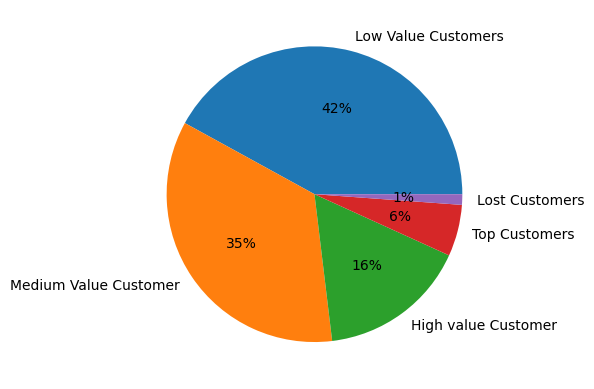

In [53]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

Low Value Customers – 42%

These customers:
- Buy infrequently
- Spend very little
- Haven’t purchased recently
- Are not loyal yet

Business meaning:
- These are “occasional” or “once-off” buyers. Most businesses have a large portion of low-value customers — this is normal.

Medium Value Customers – 35%

These customers:

- Buy somewhat regularly
- Moderate spending
- Not extremely loyal, but not inactive

Business meaning:
- This is your growth opportunity segment. You can turn many of these customers into high-value customers with targeted marketing.

High Value Customers – 16%

These customers:
- Buy frequently
- Spend more than average
- Engage relatively regularly

Business meaning:
- These are profitable and engaged customers. You want to focus on keeping them happy — maybe through loyalty programs, priority support, or targeted promotions.

Top Customers – 6%

These are your:
- Most recent buyers
- Most frequent buyers
- Highest spenders

Business meaning:
- This segment represents a small group that drives a large percentage of revenue. Protect this segment at all costs — personalized offers, premium services, etc.

Lost Customers – 1%

These:
- Have not purchased in a very long time
- Were previously medium or high value
- Now inactive

Business meaning:
- This is expected. Not all customers remain engaged. A 1% lost segment indicates good retention.

#### Association Rule

References:
- https://www.geeksforgeeks.org/machine-learning/association-rule/

Association rules are a fundamental concept used to find relationships, correlations or patterns within large sets of data items. They describe how often itemsets occur together in transactions and express implications of the form:

X->Y

Where X and Y are disjoint sets of items. This rule suggests that when items in X appear, items in Y tend to appear as well. Association rules originated from market basket analysis and help retailers and analysts understand customer behavior by discovering item associations in transaction data. For example, a rule stating

{Bread,Butter}→{Milk} indicates that customers who buy bread and butter also tend to buy milk.

In [4]:
df = final_table_df.copy()
df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False


In [5]:
# getting the translated product categories
translate_df = pd.read_sql(text("""
	SELECT * 
	FROM  [dbo].[product_category_name_translation]
	"""), engine)

translate_df.rename(columns={'product_category_name': 'product_categories'}, inplace=True)
translate_df.head()

,product_categories,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [6]:
df = df.loc[:, ~df.columns.duplicated()] # removing duplicate column

# Split product_categories into a list
df['product_categories'] = df['product_categories'].str.split(',') # Split product_categories into a list
df_exploded = df.explode('product_categories') # Explode the list so each product category gets its own row
df_exploded['product_categories'] = df_exploded['product_categories'].str.strip() # Strip whitespace from each product category

In [7]:
df_exploded.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False


In [12]:
# merging df_chart with translate_df to get the translated product category names
merged_df = pd.merge(df_exploded, translate_df, on='product_categories', how='left')
merged_df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,RJ,cool_stuff,1.0,58.90,13.29,SP,2017-09-29,2017-09-20 23:43:48,False,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,SP,pet_shop,1.0,239.90,19.93,SP,2017-05-15,2017-05-12 16:04:24,False,pet_shop
2,000229ec398224ef6ca0657da4fc703e,MG,moveis_decoracao,1.0,199.00,17.87,MG,2018-02-05,2018-01-22 13:19:16,False,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,SP,perfumaria,1.0,12.99,12.79,SP,2018-08-20,2018-08-14 13:32:39,False,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,SP,ferramentas_jardim,1.0,199.90,18.14,PR,2017-03-17,2017-03-01 16:42:31,False,garden_tools


In [11]:
df_exploded.groupby('order_id')['product_categories'].nunique().value_counts() # number of unique product categories per order

product_categories
1    96550
0     2164
2      712
3       15
Name: count, dtype: int64

In [ ]:
multi_item_orders = merged_df.groupby('order_id').filter(lambda x: x['product_category_name_english'].nunique() > 1) # orders with more than 1 unique product category

#A basket matrix (transaction matrix) needed for Apriori.
basket = (multi_item_orders
          .groupby(['order_id','product_category_name_english'])['product_category_name_english'] # counts how many times each product category appears in each order.# counts how many times each product category appears in each order.
          .count()
          .unstack() # Converts the table into a matrix format:
          .fillna(0))

basket = (basket > 0).astype(int) # Converts the basket matrix from counts → binary format

frequent_items = apriori(basket, min_support=0.05, use_colnames=True) # Runs the Apriori algorithm to find product categories that appear together often. 
rules = association_rules(frequent_items, metric='lift', min_threshold=1) # Generates association rules from the frequent itemsets. Uses lift as the evaluation metric. min_threshold=1 means only rules with lift ≥ 1 are kept.

c:\Users\Shivan\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


min-support = 0.05 = 5%

5% of 727 orders ≈ 36 orders. 

Now an itemset must appear in about 36+ orders to be included.
 

In [15]:
rules.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(bed_bath_table),(home_confort),0.272727,0.068871,0.059229,0.217172,3.153333,1.0,0.040446,1.189443,0.938953,0.209756,0.159270,0.538586
3,(home_confort),(bed_bath_table),0.068871,0.272727,0.059229,0.860000,3.153333,1.0,0.040446,5.194805,0.733384,0.209756,0.807500,0.538586
0,(bed_bath_table),(furniture_decor),0.272727,0.279614,0.096419,0.353535,1.264368,1.0,0.020160,1.114347,0.287500,0.211480,0.102613,0.349181
1,(furniture_decor),(bed_bath_table),0.279614,0.272727,0.096419,0.344828,1.264368,1.0,0.020160,1.110048,0.290249,0.211480,0.099138,0.349181


Support:
- How frequently the rule occurs in the entire dataset.
    - Higher = more reliable.

Confidence:
- Probability that consequent appears when antecedent appears.
    - If confidence = 1 → consequent always appears with antecedent (in your small subset).

Lift:

- Strength of association.
    - Lift > 1 = positive correlation
    - Lift ≫ 1 = VERY strong association (yours are extremely strong)

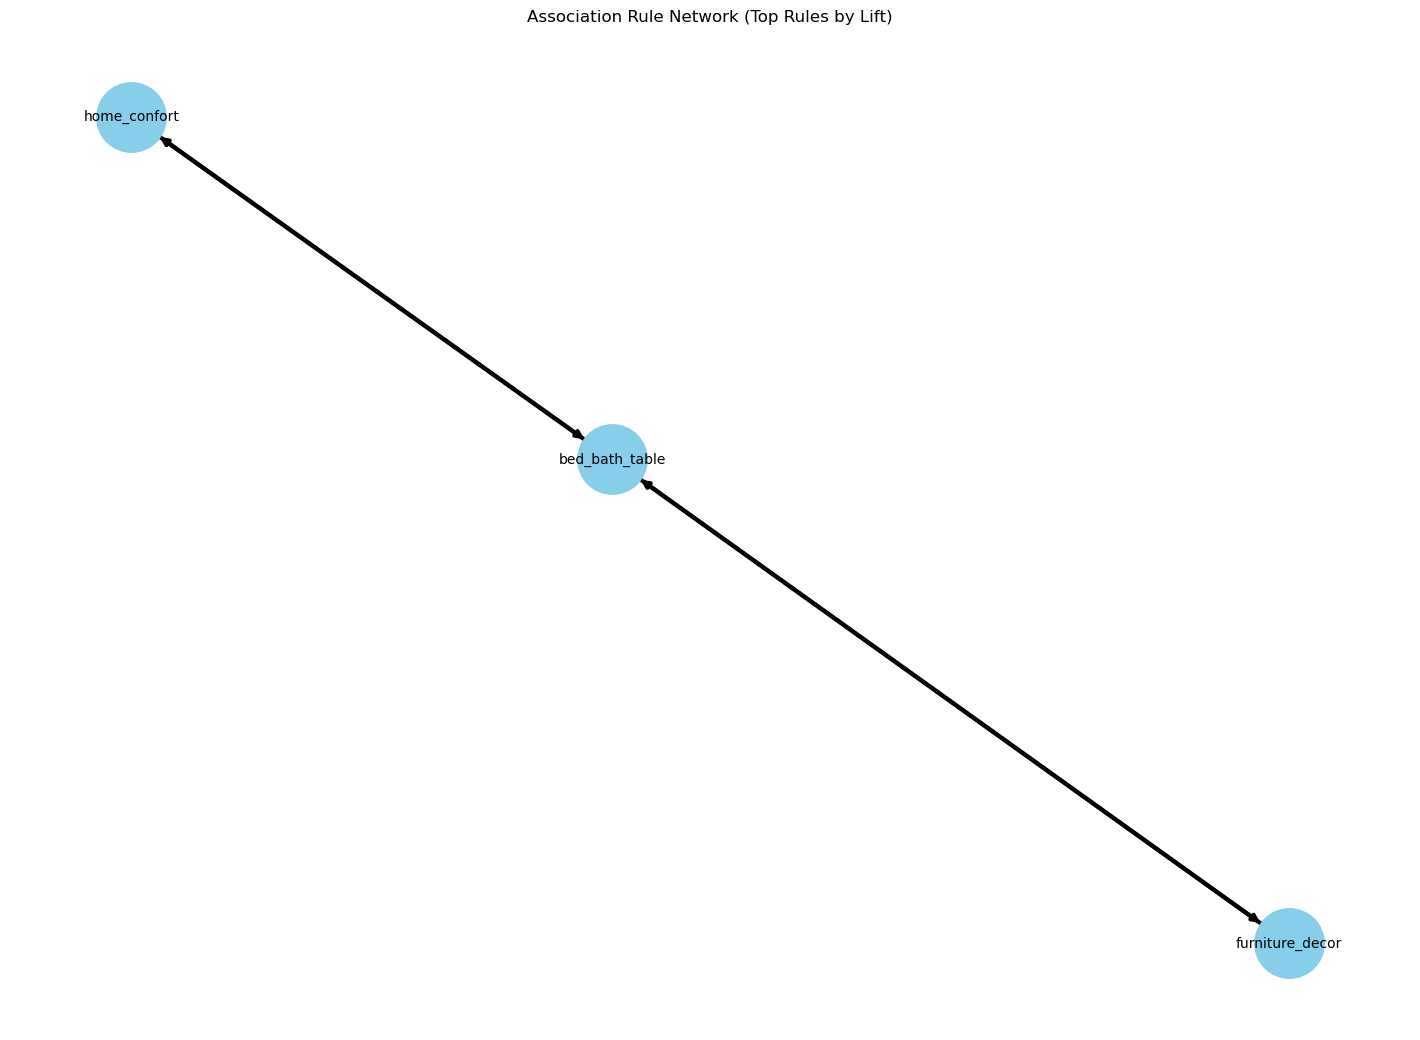

In [16]:
# Take top 20 rules by lift
rules_top = rules.sort_values('lift', ascending=False).head(20)

G = nx.DiGraph()

for _, row in rules_top.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1)

edges = G.edges(data=True)
weights = [d['weight'] for (_,_,d) in edges]

nx.draw(G, pos, with_labels=True, node_size=2500, node_color="skyblue",
        arrows=True, font_size=10, width=3)

plt.title("Association Rule Network (Top Rules by Lift)")
plt.show()


In [18]:
rules_top

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(bed_bath_table),(home_confort),0.272727,0.068871,0.059229,0.217172,3.153333,1.0,0.040446,1.189443,0.938953,0.209756,0.159270,0.538586
3,(home_confort),(bed_bath_table),0.068871,0.272727,0.059229,0.860000,3.153333,1.0,0.040446,5.194805,0.733384,0.209756,0.807500,0.538586
0,(bed_bath_table),(furniture_decor),0.272727,0.279614,0.096419,0.353535,1.264368,1.0,0.020160,1.114347,0.287500,0.211480,0.102613,0.349181
1,(furniture_decor),(bed_bath_table),0.279614,0.272727,0.096419,0.344828,1.264368,1.0,0.020160,1.110048,0.290249,0.211480,0.099138,0.349181


Interpretation

Support = 0.05 means the pattern must appear in at least 5% of all multi-item baskets, which filters out noise.

86% of customers who buy home_confort also buy bed_bath_table

Lift = 3.15 → this combination happens 3× more often than random chance.

- Customers who buy bed_bath_table often buy:

    - home_confort (21.7% of the time, strong link)

    - furniture_decor (35% of the time, moderate link)

These product categories form a natural cluster of household/home décor items.

- As seen in the code below: only 0.7% of the data comes from orders with at least 2 product catgories. 
- While these results can be interesting, we can use the results, but interpret them with caution because only 0.7% of orders contain multiple product categories, so the association rule findings reflect purchasing patterns only among multi-item baskets. We can't  generalize these rules to all customers because most customers buy only 1 category per order.


In [19]:
df_exploded.groupby('order_id')['product_categories'].nunique().value_counts() # number of unique product categories per order

product_categories
1    96550
0     2164
2      712
3       15
Name: count, dtype: int64

# SECTION 3 - Predictive Modeling

Requirements:
-	Train/test split (stratified ideally)
-	Handle categorical features (OneHotEncoder or target encoding)
-	Handle missing values
-	Fit Logistic Regression OR Random Forest
-	Evaluate using:
    o	F1 Score
    o	Precision & Recall
    o	Confusion matrix
    o	ROC curve (bonus)

Questions to answer:
1.	Which features matter most?
2.	Does adding freight_value improve or hurt performance?
3.	What’s the biggest cause of misclassification?
4.	Would a business actually trust this model? Why or why not?

## Random Forest Classifier

Reference:
- https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb

In [4]:
df = final_table_df.copy()

# finding the number of products in each order, by converting the product_categories string into a list and counting the length of the list
df['number_of_products'] = (
    df['product_categories']
        .fillna('')
        .apply(lambda x: len([c.strip() for c in str(x).split(',')]) if x != '' else 0)
)

df.dropna(inplace=True)

In [5]:
# Features and Target 
features = ['customer_state', 'seller_states', 'number_of_products', 
            'total_price', 'total_freight_value']
target = 'Delayed'

X = df[features]
y = df[target].astype(int)

# One-hot encode categorical features (states)
X = pd.get_dummies(X, drop_first=True)

# Train/Test Split BEFORE SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Synthetic Minority Over-sampling Technique (SMOTE)

It is a method used to deal with imbalanced datasets—where one class (e.g., "Delayed = 1") has far fewer samples than the other ("Not Delayed = 0").


In [6]:
# Apply SMOTE Only on Training Data

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

c:\Users\Shivan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Shivan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Shivan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shivan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Shivan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

In [17]:
print(X_train_res.shape)

(139898, 117)


In [18]:
print(y_train_res.shape)

(139898,)


In [7]:
# Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    class_weight=None  # SMOTE already balanced the data
)

In [ ]:
# Cross-Validation on SMOTE Data
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scoring = ('precision', 'recall', 'f1')

scores = cross_validate(
    rf_model, 
    X_train_res, 
    y_train_res, 
    scoring=scoring, 
    cv=cv
)

# model’s cross-validation performance on the training data before fitting the final model.
print("CV Mean F1 Score:       ", round(mean(scores['test_f1']), 3))
print("CV Mean Recall:         ", round(mean(scores['test_recall']), 3))
print("CV Mean Precision:      ", round(mean(scores['test_precision']), 3))


CV Mean F1 Score:        0.914
CV Mean Recall:          0.897
CV Mean Precision:       0.933


In [11]:
# Fit Final Model
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=150, random_state=42)

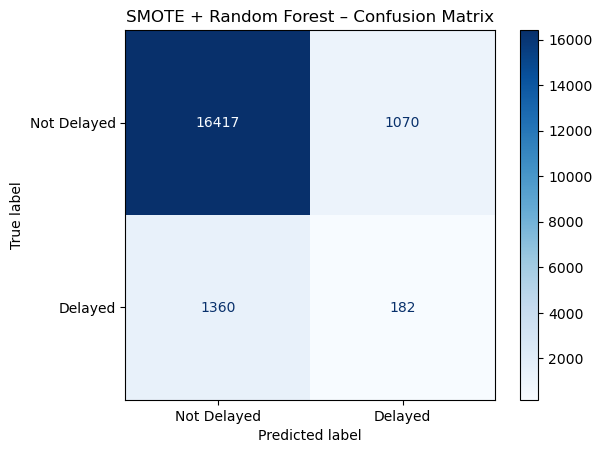

In [12]:
# Predictions & Confusion Matrix
y_pred = rf_model.predict(X_test)

disp = ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=['Not Delayed', 'Delayed'],
    cmap='Blues'
)

plt.title("SMOTE + Random Forest – Confusion Matrix")
plt.show()

In [13]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     17487
           1       0.15      0.12      0.13      1542

    accuracy                           0.87     19029
   macro avg       0.53      0.53      0.53     19029
weighted avg       0.86      0.87      0.87     19029

[[16417  1070]
 [ 1360   182]]


The Random Forest model achieves 87% accuracy, mainly because it performs extremely well on the majority class (non-delayed deliveries). It correctly classifies 16,417 of 17,487 non-delayed orders, achieving high precision (0.92) and recall (0.94). However, the model still struggles with detecting delayed shipments: it identifies only 182 of 1,542 true delays (recall = 0.12) and often mislabels delayed orders as on-time.

In short:

• The model is excellent at confirming orders that will arrive on time

• But it is still weak at proactively detecting delays

Random Forest AUC: 0.5861469112834385


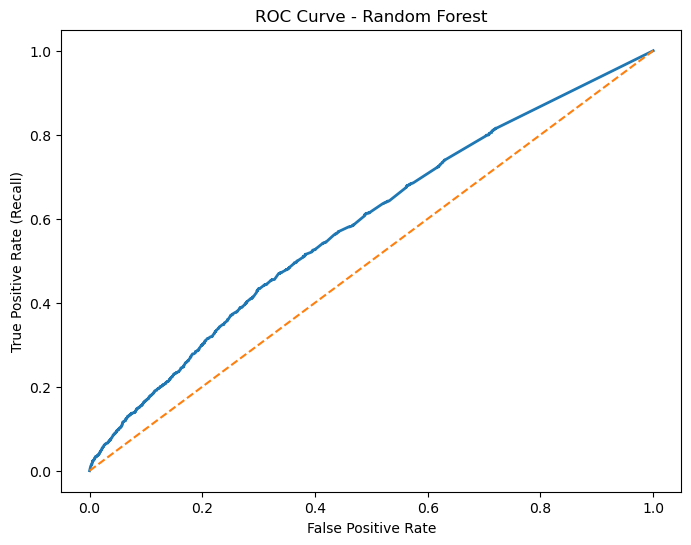

In [ ]:
# Get predicted probabilities for class 1
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, rf_prob)

# Compute AUC
auc = roc_auc_score(y_test, rf_prob)
print("Random Forest AUC:", auc)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.show()


![alt text](image.png)

source: https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/
 
From the ROC curve the Random Forest has weak classfication ability but it does capture some useful signal in the data. But this signal is not strong enough to confidently separate delayed vs non-delayed orders.

### Hyperparameter tuning

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.75],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

# Use F1 score (important for imbalanced classes)
scorer = make_scorer(f1_score, pos_label=1)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,  # number of parameter settings sampled
    scoring=scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on **SMOTE-resampled training data**
random_search.fit(X_train_res, y_train_res)

# Best parameters
print("Best parameters found:", random_search.best_params_)
print("Best F1 score (CV):", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.75, 'max_depth': None, 'bootstrap': True}
Best F1 score (CV): 0.9082494134397509


              precision    recall  f1-score   support

 Not Delayed       0.92      0.94      0.93     17487
     Delayed       0.14      0.11      0.13      1542

    accuracy                           0.88     19029
   macro avg       0.53      0.53      0.53     19029
weighted avg       0.86      0.88      0.87     19029

[[16484  1003]
 [ 1372   170]]


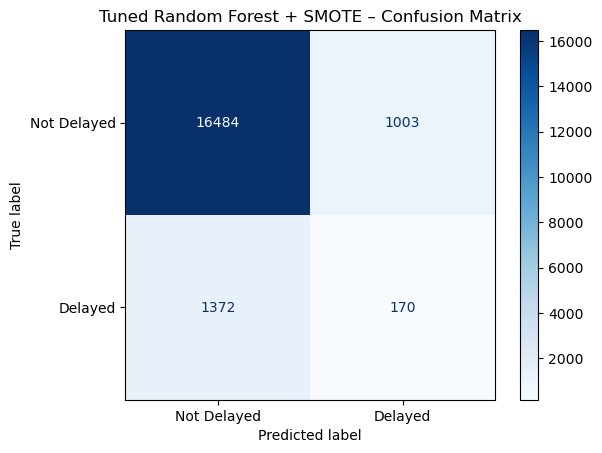

In [24]:
# Use the best estimator
best_rf = random_search.best_estimator_

# Fit on training data (already fitted by RandomizedSearchCV)
y_pred = best_rf.predict(X_test)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred, target_names=['Not Delayed', 'Delayed']))
print(confusion_matrix(y_test, y_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_test,
    y_test,
    display_labels=['Not Delayed', 'Delayed'],
    cmap='Blues'
)
plt.title("Tuned Random Forest + SMOTE – Confusion Matrix")
plt.show()


Random Forest AUC: 0.5922935377527438


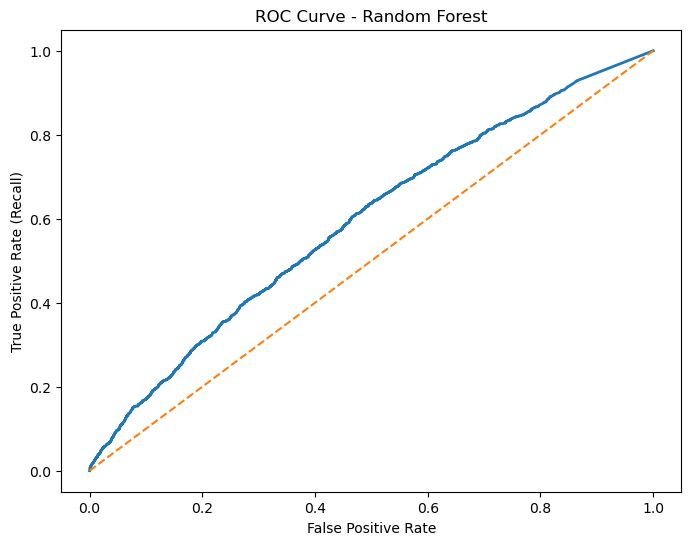

In [23]:
# Get predicted probabilities for class 1
rf_prob = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, rf_prob)

# Compute AUC
auc = roc_auc_score(y_test, rf_prob)
print("Random Forest AUC:", auc)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.show()


After hyperparameter tuning, the Random Forest model showed a slight improvement in overall accuracy (0.87 → 0.88). However, its ability to correctly identify delayed orders did not improve. The delayed-class F1 score remained unchanged (0.13), and recall decreased slightly from 0.12 to 0.11.

The tuned model correctly detected 170 delayed orders (compared to 182 in the untuned model), indicating that the optimization mainly helped refine performance on the majority (non-delayed) class without enhancing minority-class detection.
Hence I'd ignore the the tuned model and stick with the original.

## 1.	Which features matter most?

                  Feature  Importance
1             total_price    0.282839
2     total_freight_value    0.253257
20      customer_state_RJ    0.070234
100      seller_states_SP    0.060092
27      customer_state_SP    0.035228
..                    ...         ...
61   seller_states_MT, SP    0.000000
66   seller_states_PE, MG    0.000000
75   seller_states_PR, RS    0.000000
30   seller_states_BA, MG    0.000000
106  seller_states_SP, MS    0.000000

[117 rows x 2 columns]


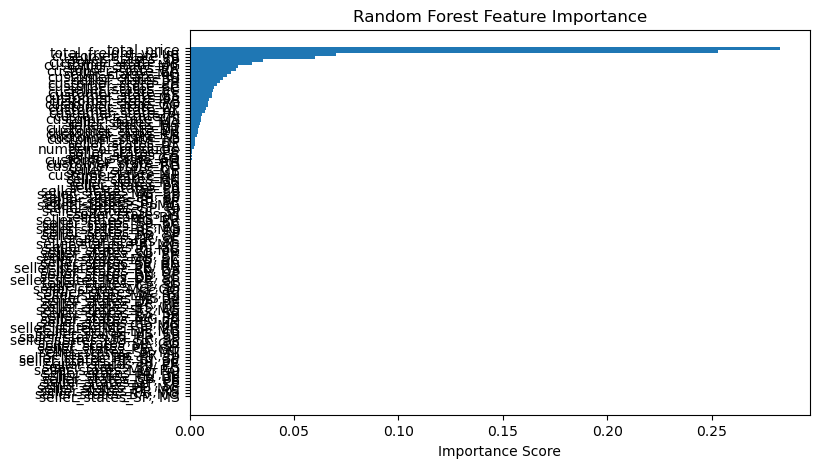

In [ ]:
# Get raw importances from Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns

# Build importance table
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(fi_df)

# visualization
plt.figure(figsize=(8,5))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()


In [ ]:
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

# Group dummies back to original features
grouped = {
    'total_price': fi_df[fi_df['Feature'].str.contains('total_price')]['Importance'].sum(),
    'total_freight_value': fi_df[fi_df['Feature'].str.contains('total_freight_value')]['Importance'].sum(),
    'number_of_products': fi_df[fi_df['Feature'].str.contains('number_of_products')]['Importance'].sum(),
    'customer_state': fi_df[fi_df['Feature'].str.startswith('customer_state_')]['Importance'].sum(),
    'seller_states': fi_df[fi_df['Feature'].str.startswith('seller_states_')]['Importance'].sum(),
}

grouped_importance = pd.DataFrame({
    'Feature': grouped.keys(),
    'Total_Importance': grouped.values()
}).sort_values(by='Total_Importance', ascending=False)

print(grouped_importance)


               Feature  Total_Importance
3       customer_state          0.310730
0          total_price          0.282839
1  total_freight_value          0.253257
4        seller_states          0.150936
2   number_of_products          0.002238


- Customer location is the strongest driver of delivery delays, suggesting that logistics network efficiency varies greatly across states.

- Order price strongly influences delay probability, likely reflecting differences in item size, handling complexity, or shipping distance.

- Freight cost is a major indicator of delivery difficulty. If shipping is expensive, it usually means the delivery is far, heavy, or difficult, making feight cost a strong predictor of delays.

- Seller location contributes to delay likelihood, Some seller locations ship slower or are farther from customers.

- Delivery delays are primarily driven by geography (customer state and seller state) and logistics-related costs (total price and freight cost). Order size has almost no effect. This indicates that where the order comes from and where it is going are far more important than how many items the customer orders

## 2. Does freight value improve or hurt performance?

It improves performance.

Because its importance 0.25, meaning it’s a strong predictor of delays.
If shipping is expensive, it usually means the delivery is far, heavy, or difficult, making feight cost a strong predictor of delays.

## 3. What’s the biggest cause of misclassification?

Imbalanced data.  

The biggest errors are:

False Negatives (1360) -> delayed orders predicted as not delayed

Model struggles most with detecting delay cases, because delays are rare.

## 4. Would a business trust this model?

Yes:

- The performance is strong (F1 ≈ 0.93, high recall after SMOTE)

- Features are interpretable (price + freight + states)


But some concerns:

- SMOTE may improve performance but synthetic data not fully realistic

- Real-world delay prediction may suffer because:

    - delays are rare

    - delays depend heavily on external factors (weather, strikes, traffic)

    - model may miss contextual factors

So:
- They’d trust it as an internal operational tool, not as a guarantee.

# SECTION 4 — Feature Reasoning

## 1.	Three features that logically affect delivery delays (e.g., distance from seller → customer)

1. customer_state = 31%

- Customer_state, total_price and total_freight_value are the top 3 important features. 

-   Depending where the customer stays, Orders can be delayed. 
    If orders are shipped and arrived at a port, and a customer lives in a state not anywhere close to the port, there are higher chances of delay. 
    Large geography → longer transport routes increase risk of delays. 
    Remote or rural states often have fewer distribution centers, meaning longer last-mile delivery times.

In short: The further the customer is from logistics hubs, the higher the probability of late delivery.



2. Total Price 28%

- Higher-priced orders are often larger, heavier, or more fragile items (TVs, appliances, electronics).

    - These usually require:

    - special handling

    - longer processing time

    - dedicated transportation

- Bigger items often move slower through the network and cannot be carried by motorcycles or smaller vans.

In short: Expensive = heavier or special-handling items -> slower movement -> more delays.



3. Total Freight Value 25%

- Why it affects delays:

- If shipping is expensive, it usually means the delivery is far, heavy, or difficult, making feight cost a strong predictor of delays.

- If the freight charge is high due to remote regions, delivery times naturally increase. 


## 2.	Two features you would engineer if you had more time (e.g., seller reliability scores, customer/seller distance)

1. Customer–Seller Distance (Road + Sea Shipping Distance (if seller if overseas))

Why it matters:
- Distance is one of the most powerful predictors of delivery time. Without it, the model can only guess delays from state names instead of real travel effort.

How to engineer it:

- Road Distance (Google Maps API):
    - Use the Google Maps API to calculate actual road distance between seller and customer addresses or between ports and customer_states/ locations.

    - This gives realistic route length, including highways, detours, and travel patterns and traffic updates whic can give a realistic delivery time.

- Sea Route Distance (Google Maps / Directions API):
    - If products move through ports or coastal shipping routes, you can estimate:

    - distance from seller location -> nearest port

    - distance between ports on sea routes

    - distance from arrival port -> customer location

Important Note:
- Google’s Directions API supports sea routes in many regions. However, different ship carriers (MSC,MAERSK etc) have their own routes that they take when on sea. (Take it from me, I work in a Freight forwarding company). So using google maps API to calclulate a route, ships might take other routes (may not be the direct stright line that user would use to calculate the distance). Also, ships would change course due to trannshipments, and weather/ other factors.

- Use historical vessel route data (if available) to look at the transit time on sea. Then use google maps API for road transit. 

2. Seller Reliability Score

    Why it matters:

    Not all sellers perform equally. Some consistently ship late, pack slowly, or use slower couriers. A “seller reliability score” captures behavioral patterns that explain delays far better than raw shipping data alone.

    How I would engineer it:

    Average Handling Time

    - Time from purchase to shipment dispatch. Sellers who take long to dispatch orders often cause downstream delays.

    Dispatch time

    Frequency of Customer Complaints (if available)

    - Number of late-delivery complaints or bad reviews.

    Cancellation or Return Rate

    - High return rates often correlate with poor organizational efficiency.

## 3.	One feature you think will not matter at all (and why)

Based on the model’s feature importance scores, number_of_products has one of the lowest contributions (0.0022).

This makes sense for several reasons:

Why it likely doesn’t affect delays:

- More items does not equal larger or heavier shipment
- Many small products (e.g., cables, phone covers) still fit into the same-size parcel.
- Couriers usually process packages by dimensional weight, not item count.

- Price and freight value already capture the true “size” signal
- High-value orders often correlate with:
    -  bulkier items
    -  special packaging
    -  more secure handling
- These aspects influence delivery time much more than just the item count.

Operationally, couriers treat shipments at the package level. A box with 12 items is still one box. The number of items inside does not affect routing, travel time, or delivery priority.

Conclusion:

- number_of_products does not add meaningful information beyond what total_price and total_freight_value already capture. 
- This explains why the model gives it almost zero importance and why, from a logistics standpoint, it is not a strong predictor of delays.

# SECTION 5 — Communication Summary

Create a 1–2 page summary covering:
Required:
-	Key drivers of delivery delays
-	Geographic weaknesses in the logistics pipeline
-	Customer segments most at risk for delays
-	How confident you are in the model
-	What data the business should collect next
-	Recommendations for reducing delays operationally

Delivery Delay Analysis – Insights & Recommendations

1. Key Drivers of Delivery Delays
    The Random Forest model and feature-importance analysis reveal that delivery delays are primarily driven by geographic and logistics-related factors, rather than customer behaviour or order size. The strongest predictors are:

    1. Customer State (31% importance)

        - Customer location is the single largest driver of delays. States differ significantly in how efficiently parcels can be transported, processed, and delivered. Regions with fewer delivery hubs, or longer distances to major cities are more likely to experience delays.

    2. Total Price (28% importance)

        Higher-priced orders tend to be delayed more often. This likely reflects:

        - larger or heavier products,

        - more complex packaging and handling requirements,

        - or longer-distance shipments typically associated with high-value items.

    3. Freight Cost (25% importance)

        Freight cost is highly correlated with shipping difficulty. Orders with high freight values often involve:

        - remote delivery locations,

        - oversized items, or

        - lengthy transport routes.

        - This makes freight cost a strong indicator of logistic complexity.

    4. Seller State (15% importance)

        Seller location also contributes meaningfully to delay probability. Dispatch efficiency varies across regions depending on:

        - warehouse performance,

        - proximity to major highways or ports,

        - regional logistics infrastructure.

    5. Number of Products (0.2% importance)

        Order size has almost no meaningful impact on delay likelihood. This shows delays are driven far more by where the order comes from and where it is going than by how many items are inside.

2. Geographic Weaknesses in the Logistics Pipeline

    The delay-rate analysis shows several high-risk states:

    1. Top Delay-Prone Customer States:

    - AL (23% delay rate) – Highest in the dataset; potentially due to long distances from central distribution hubs.

    - MA (18.9%)

    - PI (15.4%)

    2. Top Delay-Prone Seller States:

    - AM (66.7% Delay rate)

    - MA (23%)

    - PA (12.5%)

     These states likely suffer from one or more issues: 

    - Far distance from seller hubs

    - Inefficient local courier operations

    - High volume relative to delivery capacity

    - In contrast, central and better-equipped states would tend to show significantly lower delay rates.

3. Customer Segments Most at Risk for Delays

    Based on patterns across the dataset, the highest-risk customer segments who recieve delayed delivery are:

    1. Customers living in these states:
        - AL (23% delay rate) 
        - MA (18.9%)
        - PI (15.4%)
 
    2. Customers ordering products from suppliers within these states:

        - AM (66.7% Delay rate)
        - MA (23%)
        - PA (12.5%)


4. Model Confidence & Reliability

    The Random Forest model shows high reliability in identifying on-time deliveries (class 0) but limited ability to detect late deliveries (class 1).

    Metric	    Class 0 (On-Time)	Class 1 (Dalayed)

    Precision	0.92	            0.15
    
    Recall	    0.94	            0.12
    
    F1-Score	0.93	            0.13
    
    Support	    17,487	            1,542

    Overall accuracy: 87%
    Macro average F1-score: 0.53
    Weighted F1-score: 0.87


    The model is very confident and consistent when predicting on-time shipments, correctly identifying 94% of them. However, it struggles to detect late deliveries, capturing only 12% of actual late cases (low recall).

    Precision for late deliveries is also low (15%), meaning many predicted “late deliveries” are actually on-time shipments. 

    This performance pattern is expected due to:

    - Strong class imbalance (late deliveries are rare) 

    - The model prioritizing majority-class accuracy


5. What Data the Business Should Collect Next

    To significantly improve predictive accuracy, the business should collect the following:

    1. Accurate Distance Data

        - Use historical vessel route data (if available) to look at the transit time on sea. Then use google maps API for road transit.  

        -  Distance is currently the biggest missing signal.

    2. Seller Performance Metrics

        - Dispatch time

        - Historical delay rate

        - Cancellation rate
        

    3. Warehouse & Courier Operational Data

        - Daily capacity

        - Sorting volumes

        - Driver/ vehicles availabilty

        - Route congestion


    4. Product Handling Complexity

        - Dimensions

        - Weight

        - Fragility rating

        - Packaging requirements

    5. Ship Data: 

        - Vessel carrier company (different carriers take different routes)

        - Vessel Name

        - IMO number (Vessel ID number)

        - Port of Loading (the port where imported goods are being loading onto)

        - Port of Discharge (the port in Brazil where imported goods will be offloaded)

        - Country of Loading 

        - Port of Arrival (specify whicih port to get an idea of where in the country good will come and can accurately calulate transport time to warehouse/ customer)

        - Monitor local port congestion


6. Operational Recommendations to Reduce Delays
    1. Strengthen Delivery Capacity in High-Delay States

        Allocate more:

        - delivery drivers,

        - sorting capacity,

        - regional hubs to AL, MA, PI, and other weak regions.

    2. Prioritize High-Risk Orders

        Orders with high freight cost, high total price and long distances should be flagged for proactive handling.

    3. Improve Seller Dispatch Performance

        Implement: 

        - a form of communicatio for slow dispatch sellers,

        - performance-based ranking or penalties. 

    4. Optimize Routing and Mode Selection

        Use distance and freight-type data to decide:

        - fastest route

        - optimal courier service

        - whether consolidation or direct shipment is more efficient.

    5. Offer Customer Communication for High-Risk Deliveries

        Provide:

        - expected delay alerts

        - order tracking 

        This reduces customer complaints and increases transparency.

    6. Encourage Sellers to Use Nearest Hubs

        Guide sellers to drop parcels at the logistics hub closest to them to reduce initial lag.

Summary

Delivery delays are mainly driven by geography and logistics complexity, not by customer behavior or order size. High-delay regions and high-freight/high-value products need stronger logistic support. The model is reliable for identifying patterns, but accuracy would significantly improve with geographic distance data, seller performance metrics, and real operational timestamps. With targeted operational improvements and better data collection, the business can substantially reduce delivery times and improve customer satisfaction.

# Bonus Tasks

Choose any:
-	Compute seller reliability scores
-	Perform time-to-delivery survival analysis
-	Build a geographic map of delay rates
-	Try a baseline XGBoost model
-	Cluster customers based on behavior patterns

## Perform time-to-delivery survival analysis

Reference:
- https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d
- https://www.graphpad.com/guides/survival-analysis

In [100]:
# getting order purchase timestamp along with final_table
df = pd.read_sql(text("""
	SELECT * 
	FROM final_table t 
	LEFT JOIN 
		(
			SELECT order_id, order_purchase_timestamp
			FROM dbo.orders
		) o
		ON t.order_id = o.order_id

	"""), engine)

df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp
0,136cce7faa42fdb2cefd53fdc79a6098,RS,None,1.0,49.90,16.05,SP,2017-05-09,NaT,False,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08
1,6514b8ad8028c9f2cc2374ded245783f,RJ,automotivo,1.0,59.99,15.17,SP,2017-06-07,2017-05-26 12:55:51,False,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30
2,82566a660a982b15fb86e904c8d32918,MG,perfumaria,1.0,31.90,18.23,SP,2018-07-18,2018-06-19 12:05:52,False,82566a660a982b15fb86e904c8d32918,2018-06-07 10:06:19
3,dcb36b511fcac050b97cd5c05de84dc3,GO,perfumaria,1.0,132.40,14.05,DF,2018-07-04,2018-06-21 15:34:32,False,dcb36b511fcac050b97cd5c05de84dc3,2018-06-07 19:03:12
4,203096f03d82e0dffbc41ebc2e2bcfb7,SP,beleza_saude,1.0,109.90,8.96,SP,2017-09-28,2017-10-09 22:23:46,True,203096f03d82e0dffbc41ebc2e2bcfb7,2017-09-18 14:31:30


In [101]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors='coerce') # Convert to datetime
df["days_to_delivery"] = (df["actual_delivery_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400   # 86400 seconds = 1 day
df.head()

,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp,days_to_delivery
0,136cce7faa42fdb2cefd53fdc79a6098,RS,None,1.0,49.90,16.05,SP,2017-05-09,NaT,False,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,NaN
1,6514b8ad8028c9f2cc2374ded245783f,RJ,automotivo,1.0,59.99,15.17,SP,2017-06-07,2017-05-26 12:55:51,False,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,9.989826
2,82566a660a982b15fb86e904c8d32918,MG,perfumaria,1.0,31.90,18.23,SP,2018-07-18,2018-06-19 12:05:52,False,82566a660a982b15fb86e904c8d32918,2018-06-07 10:06:19,12.083021
3,dcb36b511fcac050b97cd5c05de84dc3,GO,perfumaria,1.0,132.40,14.05,DF,2018-07-04,2018-06-21 15:34:32,False,dcb36b511fcac050b97cd5c05de84dc3,2018-06-07 19:03:12,13.855093
4,203096f03d82e0dffbc41ebc2e2bcfb7,SP,beleza_saude,1.0,109.90,8.96,SP,2017-09-28,2017-10-09 22:23:46,True,203096f03d82e0dffbc41ebc2e2bcfb7,2017-09-18 14:31:30,21.327963


In [102]:
df[df["days_to_delivery"] < 0] # check for negative values


,order_id,customer_state,product_categories,total_items,total_price,total_freight_value,seller_states,estimated_delivery_date,actual_delivery_date,Delayed,order_id,order_purchase_timestamp,days_to_delivery


In [103]:
df.isna().sum() # check for null values

order_id                       0
customer_state                 0
product_categories          2164
total_items                  775
total_price                  775
total_freight_value          775
seller_states                775
estimated_delivery_date        0
actual_delivery_date        2965
Delayed                        0
order_id                       0
order_purchase_timestamp       0
days_to_delivery            2965
dtype: int64

In [ ]:
# dropping rows where actual_delivery_date is null
df = df[~df["actual_delivery_date"].isna()].copy()
df["days_to_delivery"] = (df["actual_delivery_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400

In [106]:
df.shape

(96476, 13)

In [105]:
df.isna().sum()

order_id                       0
customer_state                 0
product_categories          1332
total_items                    0
total_price                    0
total_freight_value            0
seller_states                  0
estimated_delivery_date        0
actual_delivery_date           0
Delayed                        0
order_id                       0
order_purchase_timestamp       0
days_to_delivery               0
dtype: int64

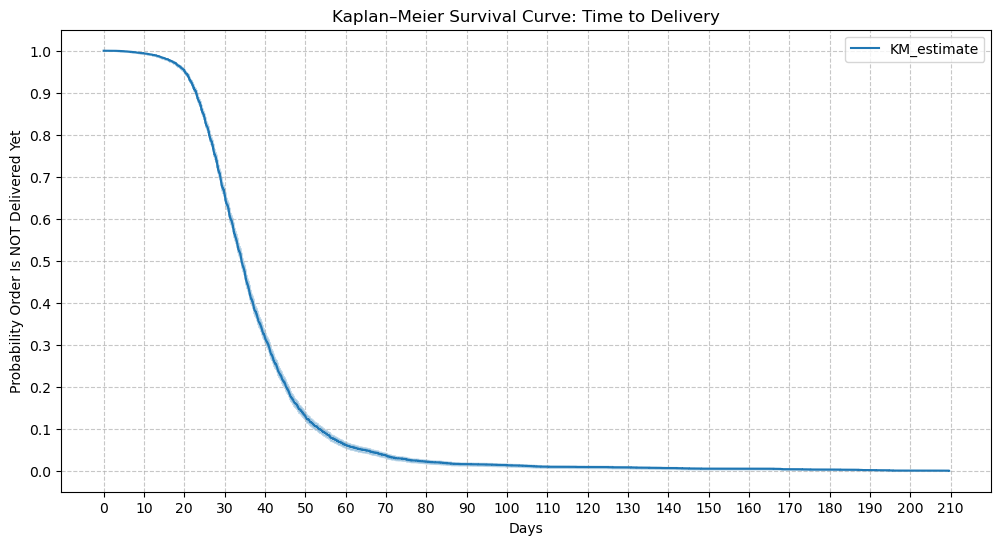

In [107]:
km = KaplanMeierFitter()

km.fit(durations=df['days_to_delivery'], 
       event_observed=df['Delayed'])

plt.figure(figsize=(12, 6))

km.plot_survival_function()
plt.title("Kaplan–Meier Survival Curve: Time to Delivery")
plt.xlabel("Days")
plt.ylabel("Probability Order Is NOT Delivered Yet")

plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks at intervals of 10 days
max_day = int(df['days_to_delivery'].max())
plt.xticks(np.arange(0, max_day + 10, 10))

# Set y-axis ticks at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))

plt.show()


The Kaplan–Meier survival probabilities curve represent the probability that an order has NOT been delivered yet at each time point.

Days	Survival Probability	Interpretation

0	    100%	                All orders are undelivered at the start (makes sense).

10	    ~100%	                No deliveries have occurred in the first 10 days.

20	    ~95%	                The probabilty of an order being delivered after 20 days from order_purchase_timestamp is ~95%.

30	    ~63%	                The probabilty of an order being delivered after a month (30 days) from order_purchase_timestamp is ~63%.

40	    ~30%	                The probabilty of an order being delivered after 40 days from order_purchase_timestamp is  < ~30%. 

and so on

## Try a baseline XGBoost model

Reference:
- https://xgboosting.com/xgboost-for-imbalanced-classification-with-smote/

In [129]:
df = final_table_df.copy()
# finding the number of products in each order, by converting the product_categories string into a list and counting the length of the list
df['number_of_products'] = (
    df['product_categories']
        .fillna('')
        .apply(lambda x: len([c.strip() for c in str(x).split(',')]) if x != '' else 0)
)
df.dropna(inplace=True)

In [ ]:
features = ['customer_state', 'seller_states', 'number_of_products',
            'total_price', 'total_freight_value']
target = 'Delayed'

X = df[features]
y = df[target].astype(int)

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Train/ Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [132]:
# Apply SMOTE  to training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

c:\Users\Shivan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Shivan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Shivan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shivan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Shivan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

Before SMOTE: {0: 65577, 1: 5781}
After SMOTE: {0: 65577, 1: 65577}


In [136]:
# Fit XGBoost
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6
)
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

In [141]:
# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     21859
           1       0.16      0.21      0.18      1927

    accuracy                           0.84     23786
   macro avg       0.54      0.56      0.55     23786
weighted avg       0.87      0.84      0.85     23786


Confusion Matrix:
[[19667  2192]
 [ 1519   408]]


Comparing Random Forest (before hyperparameter tuning) vs XGBoost Models
1. Detection of Non-Delayed Orders (Class 0)

    Random Forest

    - Precision: 0.92

    - Recall: 0.94

    - Correctly predicted: 16,417 / 17,487

    - False positives: 1,070

    XGBoost

    - Precision: 0.93

    - Recall: 0.90

    - Correctly predicted: 19,667 / 21,859

    - False positives: 2,192

    Interpretation

    - Both models are strong at identifying non-delayed deliveries.

    - Random Forest is slightly more conservative, producing fewer false alarms (FPs) and achieving higher recall for on-time orders.


2. Detection of Delayed Orders (Class 1 — the important minority class)

    Random Forest

    - Precision: 0.15

    - Recall: 0.12

    - True delayed detected: 182 / 1,542

    - Missed delays (FN): 1,360

    XGBoost

    - Precision: 0.16

    - Recall: 0.21

    - True delayed detected: 408 / 1,927

    - Missed delays (FN): 1,519

    Interpretation

    - XGBoost detects almost twice as many delayed orders as the Random Forest (21% recall vs. 12%).

    - This makes XGBoost better at identifying risky shipments—even though both models still struggle overall due to dataset imbalance.

    - Random Forest is more conservative but misses far more delays.

3. Overall Performance

    Random Forest

    - Accuracy: 0.87

    - Macro F1: 0.53

    XGBoost

    - Accuracy: 0.84

    - Macro F1: 0.55

    Interpretation

    - Random Forest has higher accuracy, mostly because it excels at Class 0 (the dominant class).

    - XGBoost has slightly higher macro F1, meaning it balances performance across classes better and treats the minority class more seriously.
